In [1]:
!pip install multiversity

#### Data Loader

In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from multiversity.multicare_dataset import MedicalDatasetCreator
import json

class MultiCaReDataset(Dataset):
    """Dataset class for loading MultiCaRe medical images and captions for image captioning."""

    def __init__(self, dataset_directory='medical_datasets', dataset_name='brain_tumor_mri',
                 transform=None, create_dataset=False, filters=None):
        """
        Initialize the MultiCaRe dataset for image captioning.

        Args:
            dataset_directory (str): Directory where the MultiCaRe data is stored
            dataset_name (str): Name of the specific dataset
            transform (callable, optional): Optional transform to apply to images
            create_dataset (bool): Whether to create a new dataset
            filters (list): Filters to use when creating a new dataset
        """
        self.dataset_directory = dataset_directory
        self.dataset_name = dataset_name
        self.transform = transform

        # Create dataset if requested
        if create_dataset:
            if not filters:
                # Default filters to get MRI images with captions
                filters = [
                    {'field': 'label', 'string_list': []},
                    {'field': 'caption', 'string_list': [], 'operator': 'any'}  # Any image with caption
                ]

            create_multicare_dataset(dataset_name, filters, dataset_directory)

        # Set up default image transforms if none provided
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

        # Load the dataset metadata
        all_data = self._load_metadata()

        # Filter out entries without captions
        captioned_data = [item for item in all_data if item.get('caption', '').strip()]
        print(f"Filtered to {len(captioned_data)} samples with captions")

        # Filter out entries with missing images
        self.data = self._filter_valid_images(captioned_data)
        print(f"Loaded {len(self.data)} samples with valid images and captions from {dataset_name} dataset")

    def _load_metadata(self):
        """Load the dataset metadata from JSON file."""
        try:
            # Construct path to the metadata JSON file (try both possible filenames)
            metadata_path = os.path.join(self.dataset_directory,
                                        self.dataset_name,
                                        'image_metadata.json')

            if not os.path.exists(metadata_path):
                metadata_path = os.path.join(self.dataset_directory,
                                            self.dataset_name,
                                            'images_metadata.json')

            if not os.path.exists(metadata_path):
                raise FileNotFoundError(f"Could not find metadata file for dataset {self.dataset_name}")

            print(f"Loading metadata from: {metadata_path}")

            # Read and parse the JSON file
            data = []
            with open(metadata_path, 'r') as f:
                for line in f:
                    if line.strip():  # Skip empty lines
                        data.append(json.loads(line))

            print(f"Loaded {len(data)} total entries from metadata file")
            return data

        except Exception as e:
            print(f"Error loading dataset: {e}")
            return []

    def _get_image_path(self, sample_data):
        """Determine the correct image path for a sample."""
        # Try different ways to get the image path
        if 'file' in sample_data:
            # Most common in the demo
            path = os.path.join(self.dataset_directory,
                               self.dataset_name,
                               'images',
                               sample_data['file'])
            if os.path.exists(path):
                return path

        # Try file_path
        if 'file_path' in sample_data:
            # Try different ways to interpret file_path
            possible_paths = [
                # Full path as provided
                os.path.join(self.dataset_directory, sample_data['file_path']),
                # Just the filename in images directory
                os.path.join(self.dataset_directory, self.dataset_name, 'images', os.path.basename(sample_data['file_path'])),
                # Direct path
                sample_data['file_path']
            ]
            for path in possible_paths:
                if os.path.exists(path):
                    return path

        # Try to construct one from main_image or file_id
        for id_field in ['main_image', 'file_id']:
            if id_field in sample_data:
                file_id = sample_data[id_field]

                # Try common patterns for file paths
                possible_paths = [
                    os.path.join(self.dataset_directory, self.dataset_name, 'images', file_id),
                    os.path.join(self.dataset_directory, self.dataset_name, 'images', f"{file_id}.jpg"),
                    os.path.join(self.dataset_directory, self.dataset_name, 'images', f"{file_id}.png"),
                    os.path.join(self.dataset_directory, self.dataset_name, 'images', f"{file_id}.webp"),
                    os.path.join(self.dataset_directory, 'whole_multicare_dataset', 'images', file_id),
                    os.path.join(self.dataset_directory, 'images', file_id),
                    # Try with PMC folder if it starts with PMC
                    os.path.join(self.dataset_directory, 'whole_multicare_dataset', f"PMC{file_id.split('_')[0]}" if '_' in file_id and file_id.split('_')[0].isdigit() else "", file_id)
                ]

                for path in possible_paths:
                    if os.path.exists(path):
                        return path

        # Print diagnostic info for the first few missing items
        global missing_image_counter
        if not hasattr(self, 'missing_image_counter'):
            self.missing_image_counter = 0

        if self.missing_image_counter < 5:  # Only print for the first 5 missing images
            print(f"Missing image sample data: {sample_data}")
            self.missing_image_counter += 1

        # No valid path found
        return None

    def _filter_valid_images(self, data):
        """Filter the dataset to only include samples with valid images."""
        valid_data = []
        missing_count = 0

        for sample in data:
            image_path = self._get_image_path(sample)
            if image_path is not None:
                # Add the resolved path to the sample for faster access later
                sample['_resolved_image_path'] = image_path
                valid_data.append(sample)
            else:
                missing_count += 1

        if missing_count > 0:
            print(f"Excluded {missing_count} samples with missing images")

        return valid_data

    def __len__(self):
        """Return the total number of samples."""
        return len(self.data)

    def __getitem__(self, idx):
        """Return a sample (image, caption) from the dataset."""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get data for this sample
        sample_data = self.data[idx]

        # Use the pre-resolved image path (faster than re-resolving)
        image_path = sample_data['_resolved_image_path']

        # Load the image (we know it exists at this point)
        try:
            image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            # Extract the caption
            caption = sample_data.get('caption', '')

            # For image captioning, we only need the image and caption, plus an ID for reference
            result = {
                'image': image,
                'caption': caption,
                'image_id': sample_data.get('file_id', sample_data.get('main_image', f"unknown_{idx}"))
            }

            return result

        except Exception as e:
            # This should rarely happen since we pre-validated the images
            print(f"Unexpected error loading image {image_path}: {e}")
            raise

def create_multicare_dataset(dataset_name, filters=None, dataset_directory='medical_datasets'):
    """
    Create a new MultiCaRe dataset subset if it doesn't already exist.

    Args:
        dataset_name (str): Name of the dataset to create
        filters (list): List of filter dictionaries to apply
        dataset_directory (str): Directory to store the dataset

    Returns:
        MedicalDatasetCreator: The initialized creator object
    """
    # Check if the dataset already exists
    dataset_dir = os.path.join(dataset_directory, dataset_name)
    if os.path.exists(dataset_dir):
        print(f"Dataset directory '{dataset_name}' already exists, using existing version.")
        mdc = MedicalDatasetCreator(directory=dataset_directory)
        return mdc

    # Initialize MedicalDatasetCreator
    print(f"Initializing MedicalDatasetCreator to create dataset: {dataset_name}")
    mdc = MedicalDatasetCreator(directory=dataset_directory)

    # Create new dataset with filters
    if filters:
        mdc.create_dataset(dataset_name = 'medCapAll', filter_list = [], dataset_type = 'multimodal')
        print(f"Created new dataset: {dataset_name}")
    else:
        raise ValueError("Filters must be provided to create a new dataset")

    return mdc

def get_multicare_dataloader(dataset_name, batch_size=16, shuffle=True, num_workers=4,
                            dataset_directory='medical_datasets', create_new=False, filters=None):
    """
    Create a DataLoader for a MultiCaRe dataset optimized for image captioning.

    Args:
        dataset_name (str): Name of the dataset to use
        batch_size (int): Batch size for training
        shuffle (bool): Whether to shuffle the dataset
        num_workers (int): Number of worker threads for loading data
        dataset_directory (str): Directory where MultiCaRe data is stored
        create_new (bool): Whether to create a new dataset
        filters (list): Filters to use when creating a new dataset

    Returns:
        DataLoader: PyTorch DataLoader object for the MultiCaRe dataset
    """
    # Check if the dataset already exists
    dataset_dir = os.path.join(dataset_directory, dataset_name)

    # Create the dataset only if create_new is True and the dataset doesn't exist
    create_dataset = create_new and not os.path.exists(dataset_dir)

    dataset = MultiCaReDataset(
        dataset_directory=dataset_directory,
        dataset_name=dataset_name,
        create_dataset=create_dataset,
        filters=[]
    )

    # Check if dataset is empty
    if len(dataset) == 0:
        raise ValueError(f"Dataset '{dataset_name}' has 0 valid samples after filtering. Check image paths and make sure images are accessible.")

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True
    )

    return dataloader


# Example usage for image captioning:
if __name__ == "__main__":
    # Define filters for medical images with descriptive captions
    caption_filters = [
         {'field': 'label', 'string_list': []},
         {'field': 'caption', 'string_list': [], 'operator': 'any'}  # Any image with captionaption
    ]

    # Print the dataset directory structure to help debugging
    print("\nExamining directory structure:")
    dataset_dir = 'medical_datasets/med_test'
    if os.path.exists(dataset_dir):
        print(f"Contents of {dataset_dir}:")
        for item in os.listdir(dataset_dir):
            print(f"  - {item}")
            if item == 'images' and os.path.isdir(os.path.join(dataset_dir, 'images')):
                image_dir = os.path.join(dataset_dir, 'images')
                print(f"    Contents of {image_dir} (first 5 items):")
                for img in list(os.listdir(image_dir))[:5]:
                    print(f"      - {img}")

    try:
        # Create and get a dataloader
        loader = get_multicare_dataloader(
            dataset_directory='medical_datasets',
            dataset_name='medCapAll',
            batch_size=8,
            create_new=True,
            filters=caption_filters
        )

        # Print sample batch
        for batch in loader:
            print(batch['caption'])
            print(f"Batch size: {len(batch['image'])}")
            print(f"Image shape: {batch['image'].shape}")
            print(f"Sample caption: {batch['caption'][0]}")
            break
    except Exception as e:
        print(f"Error creating dataloader: {e}")
        print("\nIf you're having issues with image paths, try these suggestions:")
        print("1. Check if images directory exists in your dataset folder")
        print("2. Verify that images are in the expected location")
        print("3. Try using the MultiCaRe examples to create a dataset first")


Examining directory structure:
Contents of medical_datasets/med_test:
  - case_report_citations.json
  - article_metadata.json
  - image_metadata.json
  - readme.txt
  - cases.csv
  - images
    Contents of medical_datasets/med_test/images (first 5 items):
      - PMC5
      - PMC1
      - PMC3
      - PMC6
      - PMC4
Loading metadata from: medical_datasets/medCapAll/image_metadata.json
Loaded 130791 total entries from metadata file
Filtered to 130791 samples with captions
Loaded 130791 samples with valid images and captions from medCapAll dataset
["Slit-lamp photographs of the patient's eyes. Conjunctival congestion and conjunctival follicles in the left eye.", 'TTF1 immunohistochemistry labels the neoplastic cells (400x magnification).', 'Post-olaparib. Status.', 'Orthopantomogram showing missing teeth i. r. t 12,22, 31,32,41,42 and retained deciduous tooth i. r. t 81.', 'Multiple facial fractures.', 'Case 2 - Lateral projections of cerebral digital subtraction angiography showing

#### BERT Finetuning

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM#, AdamW
import torch.optim as optim
import torch
from tqdm import tqdm
#from dataloader import get_multicare_dataloader

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")

def load_dataloader():
    caption_filters = [
        {'field': 'label', 'string_list': ['mri', 'head']},
        {'field': 'caption', 'string_list': ['showing', 'demonstrates', 'reveals'], 'operator': 'any'}
    ]
    return get_multicare_dataloader(
        dataset_name='brain_tumor_mri_1742661954',
        batch_size=8,
        create_new=True,
        filters=caption_filters
    )

def convert_dataloader_captions_to_list(loader):
    print("Extracting captions from the dataloader!")
    all_captions = []
    for batch in loader:
        # batch should be a dict with key 'caption'
        # adjust if your real dataloader yields something different
        all_captions.extend(batch['caption'])
    return all_captions

def tokenize_captions(all_captions):
    # Tokenize all captions into a single batch encoding
    inputs = tokenizer(
        all_captions,
        return_tensors='pt',
        max_length=256,
        truncation=True,
        padding='max_length'
    )
    # Clone input_ids to labels
    inputs['labels'] = inputs['input_ids'].clone()
    return inputs

def create_masks_captions(tokenized_inputs):
    # tokenized_inputs is a BatchEncoding, but can behave like a dict
    input_ids = tokenized_inputs['input_ids']
    rand = torch.rand(input_ids.shape)

    # Create mask array of booleans: 15% chance, excluding special tokens
    #   101 is [CLS], 0 is [PAD], etc.
    mask_arr = (rand < 0.15) & (input_ids != 101) & (input_ids != 0)

    for i in range(mask_arr.shape[0]):
        # Mask selected tokens with the [MASK] ID = 103
        input_ids[i, mask_arr[i]] = 103

    tokenized_inputs['input_ids'] = input_ids
    return tokenized_inputs

class MediCareBertDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        # Convert each field’s element at 'idx' into a tensor
        return {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }

    def __len__(self):
        # Number of samples is the first dimension of 'input_ids'
        return self.encodings['input_ids'].shape[0]

def train(model, dataloader, epochs=1):
    # Pick a device (mps for M1, or cuda/cpu as needed)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    model.train()

    optimizer = optim.AdamW(model.parameters(), lr=1e-5)

    for epoch in range(epochs):
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            loss.backward()
            optimizer.step()

            print(f"Epoch {epoch+1} | Loss = {loss.item():.4f}")
    model.save_pretrained("MediCareBertModel")
    tokenizer.save_pretrained("MediCareBertTokenizer")

if __name__ == "__main__":
    # 1. Get your custom loader
    loader = load_dataloader()

    # 2. Collect all captions into a list
    all_captions = convert_dataloader_captions_to_list(loader)

    # 3. Tokenize them
    inputs = tokenize_captions(all_captions)

    # 4. Randomly mask 15% of tokens
    inputs = create_masks_captions(inputs)

    # 5. Create a Dataset and DataLoader for training
    dataset = MediCareBertDataset(inputs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

    # 6. Train the model
    train(model, dataloader, epochs=1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initializing MedicalDatasetCreator to create dataset: brain_tumor_mri_1742661954
The MultiCaRe Dataset is already downloaded.
Importing and pre-processing the main files.
Done!
The brain_tumor_mri_1742661954 was successfully created!
Created new dataset: brain_tumor_mri_1742661954
Loading metadata from: medical_datasets/brain_tumor_mri_1742661954/image_metadata.json
Loaded 2718 total entries from metadata file
Filtered to 2718 samples with captions
Loaded 2718 samples with valid images and captions from brain_tumor_mri_1742661954 dataset
Extracting captions from the dataloader!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1:   0%|          | 0/680 [00:00<?, ?it/s]<ipython-input-3-b1fd46904cfc>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(val[idx])
Epoch 1:   0%|          | 1/680 [00:01<12:43,  1.12s/it]

Epoch 1 | Loss = 14.9356


Epoch 1:   0%|          | 2/680 [00:01<06:43,  1.68it/s]

Epoch 1 | Loss = 13.8118


Epoch 1:   0%|          | 3/680 [00:01<04:47,  2.35it/s]

Epoch 1 | Loss = 13.4061


Epoch 1:   1%|          | 4/680 [00:01<03:53,  2.89it/s]

Epoch 1 | Loss = 9.5032


Epoch 1:   1%|          | 5/680 [00:02<03:23,  3.32it/s]

Epoch 1 | Loss = 11.6920


Epoch 1:   1%|          | 6/680 [00:02<03:05,  3.63it/s]

Epoch 1 | Loss = 11.4808


Epoch 1:   1%|          | 7/680 [00:02<02:54,  3.86it/s]

Epoch 1 | Loss = 11.7885


Epoch 1:   1%|          | 8/680 [00:02<02:45,  4.05it/s]

Epoch 1 | Loss = 10.6359


Epoch 1:   1%|▏         | 9/680 [00:02<02:40,  4.18it/s]

Epoch 1 | Loss = 10.6957


Epoch 1:   1%|▏         | 10/680 [00:03<02:36,  4.27it/s]

Epoch 1 | Loss = 10.2225


Epoch 1:   2%|▏         | 11/680 [00:03<02:34,  4.33it/s]

Epoch 1 | Loss = 10.7070


Epoch 1:   2%|▏         | 12/680 [00:03<02:32,  4.39it/s]

Epoch 1 | Loss = 10.5617


Epoch 1:   2%|▏         | 13/680 [00:03<02:31,  4.41it/s]

Epoch 1 | Loss = 9.6449


Epoch 1:   2%|▏         | 14/680 [00:04<02:30,  4.44it/s]

Epoch 1 | Loss = 8.9620


Epoch 1:   2%|▏         | 15/680 [00:04<02:29,  4.45it/s]

Epoch 1 | Loss = 7.3062


Epoch 1:   2%|▏         | 16/680 [00:04<02:29,  4.45it/s]

Epoch 1 | Loss = 8.6768


Epoch 1:   2%|▎         | 17/680 [00:04<02:28,  4.47it/s]

Epoch 1 | Loss = 8.2942


Epoch 1:   3%|▎         | 18/680 [00:04<02:28,  4.47it/s]

Epoch 1 | Loss = 7.9503


Epoch 1:   3%|▎         | 19/680 [00:05<02:27,  4.47it/s]

Epoch 1 | Loss = 7.4784


Epoch 1:   3%|▎         | 20/680 [00:05<02:27,  4.47it/s]

Epoch 1 | Loss = 7.6876


Epoch 1:   3%|▎         | 21/680 [00:05<02:28,  4.45it/s]

Epoch 1 | Loss = 6.4470


Epoch 1:   3%|▎         | 22/680 [00:05<02:27,  4.46it/s]

Epoch 1 | Loss = 7.1062


Epoch 1:   3%|▎         | 23/680 [00:06<02:26,  4.48it/s]

Epoch 1 | Loss = 6.7061


Epoch 1:   4%|▎         | 24/680 [00:06<02:26,  4.49it/s]

Epoch 1 | Loss = 6.6937


Epoch 1:   4%|▎         | 25/680 [00:06<02:26,  4.48it/s]

Epoch 1 | Loss = 6.2472


Epoch 1:   4%|▍         | 26/680 [00:06<02:25,  4.48it/s]

Epoch 1 | Loss = 6.0982


Epoch 1:   4%|▍         | 27/680 [00:06<02:25,  4.48it/s]

Epoch 1 | Loss = 5.9801


Epoch 1:   4%|▍         | 28/680 [00:07<02:25,  4.47it/s]

Epoch 1 | Loss = 5.7334


Epoch 1:   4%|▍         | 29/680 [00:07<02:25,  4.48it/s]

Epoch 1 | Loss = 6.0875


Epoch 1:   4%|▍         | 30/680 [00:07<02:25,  4.46it/s]

Epoch 1 | Loss = 5.4590


Epoch 1:   5%|▍         | 31/680 [00:07<02:25,  4.47it/s]

Epoch 1 | Loss = 5.5278


Epoch 1:   5%|▍         | 32/680 [00:08<02:25,  4.46it/s]

Epoch 1 | Loss = 4.7272


Epoch 1:   5%|▍         | 33/680 [00:08<02:24,  4.46it/s]

Epoch 1 | Loss = 5.2693


Epoch 1:   5%|▌         | 34/680 [00:08<02:24,  4.47it/s]

Epoch 1 | Loss = 4.9804


Epoch 1:   5%|▌         | 35/680 [00:08<02:24,  4.48it/s]

Epoch 1 | Loss = 4.8669


Epoch 1:   5%|▌         | 36/680 [00:08<02:23,  4.47it/s]

Epoch 1 | Loss = 4.5417


Epoch 1:   5%|▌         | 37/680 [00:09<02:23,  4.47it/s]

Epoch 1 | Loss = 4.4968


Epoch 1:   6%|▌         | 38/680 [00:09<02:23,  4.46it/s]

Epoch 1 | Loss = 4.4437


Epoch 1:   6%|▌         | 39/680 [00:09<02:23,  4.46it/s]

Epoch 1 | Loss = 4.3354


Epoch 1:   6%|▌         | 40/680 [00:09<02:24,  4.44it/s]

Epoch 1 | Loss = 4.5992


Epoch 1:   6%|▌         | 41/680 [00:10<02:24,  4.43it/s]

Epoch 1 | Loss = 4.0040


Epoch 1:   6%|▌         | 42/680 [00:10<02:24,  4.42it/s]

Epoch 1 | Loss = 4.1617


Epoch 1:   6%|▋         | 43/680 [00:10<02:23,  4.43it/s]

Epoch 1 | Loss = 3.6185


Epoch 1:   6%|▋         | 44/680 [00:10<02:23,  4.43it/s]

Epoch 1 | Loss = 3.8321


Epoch 1:   7%|▋         | 45/680 [00:10<02:23,  4.43it/s]

Epoch 1 | Loss = 3.7956


Epoch 1:   7%|▋         | 46/680 [00:11<02:23,  4.42it/s]

Epoch 1 | Loss = 3.5510


Epoch 1:   7%|▋         | 47/680 [00:11<02:23,  4.42it/s]

Epoch 1 | Loss = 3.3816


Epoch 1:   7%|▋         | 48/680 [00:11<02:23,  4.42it/s]

Epoch 1 | Loss = 3.3484


Epoch 1:   7%|▋         | 49/680 [00:11<02:22,  4.44it/s]

Epoch 1 | Loss = 3.2082


Epoch 1:   7%|▋         | 50/680 [00:12<02:21,  4.45it/s]

Epoch 1 | Loss = 2.9970


Epoch 1:   8%|▊         | 51/680 [00:12<02:21,  4.45it/s]

Epoch 1 | Loss = 3.4021


Epoch 1:   8%|▊         | 52/680 [00:12<02:21,  4.45it/s]

Epoch 1 | Loss = 3.4148


Epoch 1:   8%|▊         | 53/680 [00:12<02:20,  4.46it/s]

Epoch 1 | Loss = 3.1159


Epoch 1:   8%|▊         | 54/680 [00:12<02:20,  4.46it/s]

Epoch 1 | Loss = 2.6402


Epoch 1:   8%|▊         | 55/680 [00:13<02:20,  4.46it/s]

Epoch 1 | Loss = 2.6167


Epoch 1:   8%|▊         | 56/680 [00:13<02:19,  4.46it/s]

Epoch 1 | Loss = 2.8749


Epoch 1:   8%|▊         | 57/680 [00:13<02:19,  4.46it/s]

Epoch 1 | Loss = 2.8163


Epoch 1:   9%|▊         | 58/680 [00:13<02:19,  4.45it/s]

Epoch 1 | Loss = 2.2843


Epoch 1:   9%|▊         | 59/680 [00:14<02:19,  4.44it/s]

Epoch 1 | Loss = 2.0795


Epoch 1:   9%|▉         | 60/680 [00:14<02:19,  4.44it/s]

Epoch 1 | Loss = 2.0704


Epoch 1:   9%|▉         | 61/680 [00:14<02:19,  4.43it/s]

Epoch 1 | Loss = 1.9290


Epoch 1:   9%|▉         | 62/680 [00:14<02:19,  4.43it/s]

Epoch 1 | Loss = 1.9137


Epoch 1:   9%|▉         | 63/680 [00:15<02:19,  4.44it/s]

Epoch 1 | Loss = 1.8791


Epoch 1:   9%|▉         | 64/680 [00:15<02:18,  4.44it/s]

Epoch 1 | Loss = 1.9060


Epoch 1:  10%|▉         | 65/680 [00:15<02:18,  4.43it/s]

Epoch 1 | Loss = 1.6779


Epoch 1:  10%|▉         | 66/680 [00:15<02:18,  4.42it/s]

Epoch 1 | Loss = 2.0063


Epoch 1:  10%|▉         | 67/680 [00:15<02:18,  4.42it/s]

Epoch 1 | Loss = 1.9195


Epoch 1:  10%|█         | 68/680 [00:16<02:18,  4.42it/s]

Epoch 1 | Loss = 2.4627


Epoch 1:  10%|█         | 69/680 [00:16<02:18,  4.43it/s]

Epoch 1 | Loss = 1.4971


Epoch 1:  10%|█         | 70/680 [00:16<02:17,  4.43it/s]

Epoch 1 | Loss = 1.6965


Epoch 1:  10%|█         | 71/680 [00:16<02:17,  4.43it/s]

Epoch 1 | Loss = 1.7080


Epoch 1:  11%|█         | 72/680 [00:17<02:17,  4.41it/s]

Epoch 1 | Loss = 1.5463


Epoch 1:  11%|█         | 73/680 [00:17<02:17,  4.42it/s]

Epoch 1 | Loss = 1.5587


Epoch 1:  11%|█         | 74/680 [00:17<02:17,  4.42it/s]

Epoch 1 | Loss = 1.5197


Epoch 1:  11%|█         | 75/680 [00:17<02:16,  4.42it/s]

Epoch 1 | Loss = 1.5775


Epoch 1:  11%|█         | 76/680 [00:17<02:16,  4.43it/s]

Epoch 1 | Loss = 1.3145


Epoch 1:  11%|█▏        | 77/680 [00:18<02:16,  4.40it/s]

Epoch 1 | Loss = 1.2099


Epoch 1:  11%|█▏        | 78/680 [00:18<02:16,  4.41it/s]

Epoch 1 | Loss = 1.1413


Epoch 1:  12%|█▏        | 79/680 [00:18<02:16,  4.41it/s]

Epoch 1 | Loss = 1.5629


Epoch 1:  12%|█▏        | 80/680 [00:18<02:15,  4.41it/s]

Epoch 1 | Loss = 1.0805


Epoch 1:  12%|█▏        | 81/680 [00:19<02:15,  4.41it/s]

Epoch 1 | Loss = 1.3568


Epoch 1:  12%|█▏        | 82/680 [00:19<02:16,  4.39it/s]

Epoch 1 | Loss = 1.1336


Epoch 1:  12%|█▏        | 83/680 [00:19<02:16,  4.38it/s]

Epoch 1 | Loss = 1.0173


Epoch 1:  12%|█▏        | 84/680 [00:19<02:15,  4.39it/s]

Epoch 1 | Loss = 1.0844


Epoch 1:  12%|█▎        | 85/680 [00:20<02:14,  4.41it/s]

Epoch 1 | Loss = 1.3802


Epoch 1:  13%|█▎        | 86/680 [00:20<02:14,  4.41it/s]

Epoch 1 | Loss = 0.9786


Epoch 1:  13%|█▎        | 87/680 [00:20<02:14,  4.40it/s]

Epoch 1 | Loss = 0.9018


Epoch 1:  13%|█▎        | 88/680 [00:20<02:14,  4.40it/s]

Epoch 1 | Loss = 0.9693


Epoch 1:  13%|█▎        | 89/680 [00:20<02:14,  4.39it/s]

Epoch 1 | Loss = 1.0608


Epoch 1:  13%|█▎        | 90/680 [00:21<02:14,  4.39it/s]

Epoch 1 | Loss = 0.9588


Epoch 1:  13%|█▎        | 91/680 [00:21<02:14,  4.39it/s]

Epoch 1 | Loss = 0.8588


Epoch 1:  14%|█▎        | 92/680 [00:21<02:13,  4.39it/s]

Epoch 1 | Loss = 0.9752


Epoch 1:  14%|█▎        | 93/680 [00:21<02:13,  4.39it/s]

Epoch 1 | Loss = 1.2260


Epoch 1:  14%|█▍        | 94/680 [00:22<02:13,  4.38it/s]

Epoch 1 | Loss = 0.7674


Epoch 1:  14%|█▍        | 95/680 [00:22<02:13,  4.37it/s]

Epoch 1 | Loss = 0.7799


Epoch 1:  14%|█▍        | 96/680 [00:22<02:13,  4.38it/s]

Epoch 1 | Loss = 0.9028


Epoch 1:  14%|█▍        | 97/680 [00:22<02:12,  4.40it/s]

Epoch 1 | Loss = 0.7505


Epoch 1:  14%|█▍        | 98/680 [00:22<02:12,  4.38it/s]

Epoch 1 | Loss = 1.0484


Epoch 1:  15%|█▍        | 99/680 [00:23<02:13,  4.36it/s]

Epoch 1 | Loss = 0.8140


Epoch 1:  15%|█▍        | 100/680 [00:23<02:12,  4.38it/s]

Epoch 1 | Loss = 0.8789


Epoch 1:  15%|█▍        | 101/680 [00:23<02:12,  4.36it/s]

Epoch 1 | Loss = 0.9254


Epoch 1:  15%|█▌        | 102/680 [00:23<02:12,  4.37it/s]

Epoch 1 | Loss = 0.6591


Epoch 1:  15%|█▌        | 103/680 [00:24<02:11,  4.40it/s]

Epoch 1 | Loss = 0.7339


Epoch 1:  15%|█▌        | 104/680 [00:24<02:10,  4.40it/s]

Epoch 1 | Loss = 0.7624


Epoch 1:  15%|█▌        | 105/680 [00:24<02:10,  4.41it/s]

Epoch 1 | Loss = 0.6740


Epoch 1:  16%|█▌        | 106/680 [00:24<02:10,  4.39it/s]

Epoch 1 | Loss = 0.7004


Epoch 1:  16%|█▌        | 107/680 [00:25<02:10,  4.39it/s]

Epoch 1 | Loss = 0.5483


Epoch 1:  16%|█▌        | 108/680 [00:25<02:10,  4.39it/s]

Epoch 1 | Loss = 0.6003


Epoch 1:  16%|█▌        | 109/680 [00:25<02:10,  4.38it/s]

Epoch 1 | Loss = 0.6171


Epoch 1:  16%|█▌        | 110/680 [00:25<02:10,  4.38it/s]

Epoch 1 | Loss = 0.7213


Epoch 1:  16%|█▋        | 111/680 [00:25<02:09,  4.39it/s]

Epoch 1 | Loss = 0.6232


Epoch 1:  16%|█▋        | 112/680 [00:26<02:09,  4.40it/s]

Epoch 1 | Loss = 0.5566


Epoch 1:  17%|█▋        | 113/680 [00:26<02:09,  4.39it/s]

Epoch 1 | Loss = 0.6136


Epoch 1:  17%|█▋        | 114/680 [00:26<02:09,  4.38it/s]

Epoch 1 | Loss = 0.6218


Epoch 1:  17%|█▋        | 115/680 [00:26<02:08,  4.38it/s]

Epoch 1 | Loss = 0.5975


Epoch 1:  17%|█▋        | 116/680 [00:27<02:08,  4.39it/s]

Epoch 1 | Loss = 0.5096


Epoch 1:  17%|█▋        | 117/680 [00:27<02:08,  4.37it/s]

Epoch 1 | Loss = 0.5866


Epoch 1:  17%|█▋        | 118/680 [00:27<02:08,  4.37it/s]

Epoch 1 | Loss = 0.6068


Epoch 1:  18%|█▊        | 119/680 [00:27<02:08,  4.37it/s]

Epoch 1 | Loss = 0.6612


Epoch 1:  18%|█▊        | 120/680 [00:27<02:07,  4.38it/s]

Epoch 1 | Loss = 0.5557


Epoch 1:  18%|█▊        | 121/680 [00:28<02:07,  4.37it/s]

Epoch 1 | Loss = 0.5309


Epoch 1:  18%|█▊        | 122/680 [00:28<02:07,  4.37it/s]

Epoch 1 | Loss = 0.4845


Epoch 1:  18%|█▊        | 123/680 [00:28<02:07,  4.38it/s]

Epoch 1 | Loss = 0.4237


Epoch 1:  18%|█▊        | 124/680 [00:28<02:07,  4.36it/s]

Epoch 1 | Loss = 0.6473


Epoch 1:  18%|█▊        | 125/680 [00:29<02:07,  4.36it/s]

Epoch 1 | Loss = 0.3839


Epoch 1:  19%|█▊        | 126/680 [00:29<02:09,  4.26it/s]

Epoch 1 | Loss = 0.4784


Epoch 1:  19%|█▊        | 127/680 [00:29<02:12,  4.18it/s]

Epoch 1 | Loss = 0.5292


Epoch 1:  19%|█▉        | 128/680 [00:29<02:14,  4.12it/s]

Epoch 1 | Loss = 0.4491


Epoch 1:  19%|█▉        | 129/680 [00:30<02:11,  4.18it/s]

Epoch 1 | Loss = 0.4646


Epoch 1:  19%|█▉        | 130/680 [00:30<02:10,  4.22it/s]

Epoch 1 | Loss = 0.6796


Epoch 1:  19%|█▉        | 131/680 [00:30<02:10,  4.20it/s]

Epoch 1 | Loss = 0.4631


Epoch 1:  19%|█▉        | 132/680 [00:30<02:09,  4.22it/s]

Epoch 1 | Loss = 0.4758


Epoch 1:  20%|█▉        | 133/680 [00:31<02:09,  4.21it/s]

Epoch 1 | Loss = 0.4430


Epoch 1:  20%|█▉        | 134/680 [00:31<02:11,  4.16it/s]

Epoch 1 | Loss = 0.4848


Epoch 1:  20%|█▉        | 135/680 [00:31<02:08,  4.23it/s]

Epoch 1 | Loss = 0.5056


Epoch 1:  20%|██        | 136/680 [00:31<02:12,  4.12it/s]

Epoch 1 | Loss = 0.3697


Epoch 1:  20%|██        | 137/680 [00:32<02:10,  4.15it/s]

Epoch 1 | Loss = 0.4341


Epoch 1:  20%|██        | 138/680 [00:32<02:11,  4.11it/s]

Epoch 1 | Loss = 0.3667


Epoch 1:  20%|██        | 139/680 [00:32<02:15,  4.00it/s]

Epoch 1 | Loss = 0.4424


Epoch 1:  21%|██        | 140/680 [00:32<02:13,  4.06it/s]

Epoch 1 | Loss = 0.4686


Epoch 1:  21%|██        | 141/680 [00:33<02:09,  4.15it/s]

Epoch 1 | Loss = 0.4426


Epoch 1:  21%|██        | 142/680 [00:33<02:07,  4.21it/s]

Epoch 1 | Loss = 0.3294


Epoch 1:  21%|██        | 143/680 [00:33<02:06,  4.25it/s]

Epoch 1 | Loss = 0.3806


Epoch 1:  21%|██        | 144/680 [00:33<02:04,  4.29it/s]

Epoch 1 | Loss = 0.4461


Epoch 1:  21%|██▏       | 145/680 [00:33<02:05,  4.25it/s]

Epoch 1 | Loss = 0.4673


Epoch 1:  21%|██▏       | 146/680 [00:34<02:04,  4.28it/s]

Epoch 1 | Loss = 0.4484


Epoch 1:  22%|██▏       | 147/680 [00:34<02:04,  4.27it/s]

Epoch 1 | Loss = 0.3737


Epoch 1:  22%|██▏       | 148/680 [00:34<02:04,  4.28it/s]

Epoch 1 | Loss = 0.3197


Epoch 1:  22%|██▏       | 149/680 [00:34<02:04,  4.28it/s]

Epoch 1 | Loss = 0.3648


Epoch 1:  22%|██▏       | 150/680 [00:35<02:03,  4.30it/s]

Epoch 1 | Loss = 0.3852


Epoch 1:  22%|██▏       | 151/680 [00:35<02:03,  4.29it/s]

Epoch 1 | Loss = 0.4326


Epoch 1:  22%|██▏       | 152/680 [00:35<02:02,  4.29it/s]

Epoch 1 | Loss = 0.4336


Epoch 1:  22%|██▎       | 153/680 [00:35<02:02,  4.30it/s]

Epoch 1 | Loss = 0.3564


Epoch 1:  23%|██▎       | 154/680 [00:36<02:02,  4.31it/s]

Epoch 1 | Loss = 0.3959


Epoch 1:  23%|██▎       | 155/680 [00:36<02:01,  4.32it/s]

Epoch 1 | Loss = 0.2829


Epoch 1:  23%|██▎       | 156/680 [00:36<02:01,  4.32it/s]

Epoch 1 | Loss = 0.3738


Epoch 1:  23%|██▎       | 157/680 [00:36<02:00,  4.33it/s]

Epoch 1 | Loss = 0.3334


Epoch 1:  23%|██▎       | 158/680 [00:36<02:00,  4.32it/s]

Epoch 1 | Loss = 0.2835


Epoch 1:  23%|██▎       | 159/680 [00:37<02:00,  4.33it/s]

Epoch 1 | Loss = 0.3078


Epoch 1:  24%|██▎       | 160/680 [00:37<02:00,  4.32it/s]

Epoch 1 | Loss = 0.2117


Epoch 1:  24%|██▎       | 161/680 [00:37<02:00,  4.32it/s]

Epoch 1 | Loss = 0.2846


Epoch 1:  24%|██▍       | 162/680 [00:37<01:59,  4.34it/s]

Epoch 1 | Loss = 0.3474


Epoch 1:  24%|██▍       | 163/680 [00:38<01:59,  4.32it/s]

Epoch 1 | Loss = 0.3211


Epoch 1:  24%|██▍       | 164/680 [00:38<01:59,  4.33it/s]

Epoch 1 | Loss = 0.3347


Epoch 1:  24%|██▍       | 165/680 [00:38<01:59,  4.32it/s]

Epoch 1 | Loss = 0.2846


Epoch 1:  24%|██▍       | 166/680 [00:38<01:58,  4.32it/s]

Epoch 1 | Loss = 0.4075


Epoch 1:  25%|██▍       | 167/680 [00:39<01:58,  4.32it/s]

Epoch 1 | Loss = 0.3398


Epoch 1:  25%|██▍       | 168/680 [00:39<01:58,  4.32it/s]

Epoch 1 | Loss = 0.3887


Epoch 1:  25%|██▍       | 169/680 [00:39<01:58,  4.32it/s]

Epoch 1 | Loss = 0.3432


Epoch 1:  25%|██▌       | 170/680 [00:39<01:58,  4.32it/s]

Epoch 1 | Loss = 0.3746


Epoch 1:  25%|██▌       | 171/680 [00:39<01:57,  4.32it/s]

Epoch 1 | Loss = 0.2865


Epoch 1:  25%|██▌       | 172/680 [00:40<01:57,  4.31it/s]

Epoch 1 | Loss = 0.2313


Epoch 1:  25%|██▌       | 173/680 [00:40<01:57,  4.31it/s]

Epoch 1 | Loss = 0.2712


Epoch 1:  26%|██▌       | 174/680 [00:40<01:57,  4.30it/s]

Epoch 1 | Loss = 0.3661


Epoch 1:  26%|██▌       | 175/680 [00:40<01:57,  4.31it/s]

Epoch 1 | Loss = 0.2923


Epoch 1:  26%|██▌       | 176/680 [00:41<01:57,  4.29it/s]

Epoch 1 | Loss = 0.3234


Epoch 1:  26%|██▌       | 177/680 [00:41<01:56,  4.31it/s]

Epoch 1 | Loss = 0.2741


Epoch 1:  26%|██▌       | 178/680 [00:41<01:56,  4.29it/s]

Epoch 1 | Loss = 0.2232


Epoch 1:  26%|██▋       | 179/680 [00:41<01:56,  4.30it/s]

Epoch 1 | Loss = 0.2571


Epoch 1:  26%|██▋       | 180/680 [00:42<01:56,  4.29it/s]

Epoch 1 | Loss = 0.2882


Epoch 1:  27%|██▋       | 181/680 [00:42<01:56,  4.30it/s]

Epoch 1 | Loss = 0.3419


Epoch 1:  27%|██▋       | 182/680 [00:42<01:56,  4.28it/s]

Epoch 1 | Loss = 0.2386


Epoch 1:  27%|██▋       | 183/680 [00:42<01:55,  4.30it/s]

Epoch 1 | Loss = 0.2780


Epoch 1:  27%|██▋       | 184/680 [00:42<01:55,  4.28it/s]

Epoch 1 | Loss = 0.2515


Epoch 1:  27%|██▋       | 185/680 [00:43<01:54,  4.30it/s]

Epoch 1 | Loss = 0.2290


Epoch 1:  27%|██▋       | 186/680 [00:43<01:55,  4.29it/s]

Epoch 1 | Loss = 0.4369


Epoch 1:  28%|██▊       | 187/680 [00:43<01:54,  4.30it/s]

Epoch 1 | Loss = 0.2098


Epoch 1:  28%|██▊       | 188/680 [00:43<01:54,  4.30it/s]

Epoch 1 | Loss = 0.2602


Epoch 1:  28%|██▊       | 189/680 [00:44<01:54,  4.30it/s]

Epoch 1 | Loss = 0.2276


Epoch 1:  28%|██▊       | 190/680 [00:44<01:54,  4.29it/s]

Epoch 1 | Loss = 0.2618


Epoch 1:  28%|██▊       | 191/680 [00:44<01:53,  4.30it/s]

Epoch 1 | Loss = 0.2339


Epoch 1:  28%|██▊       | 192/680 [00:44<01:53,  4.29it/s]

Epoch 1 | Loss = 0.2658


Epoch 1:  28%|██▊       | 193/680 [00:45<01:53,  4.30it/s]

Epoch 1 | Loss = 0.2482


Epoch 1:  29%|██▊       | 194/680 [00:45<01:53,  4.29it/s]

Epoch 1 | Loss = 0.2360


Epoch 1:  29%|██▊       | 195/680 [00:45<01:52,  4.30it/s]

Epoch 1 | Loss = 0.2246


Epoch 1:  29%|██▉       | 196/680 [00:45<01:53,  4.27it/s]

Epoch 1 | Loss = 0.2319


Epoch 1:  29%|██▉       | 197/680 [00:46<01:52,  4.27it/s]

Epoch 1 | Loss = 0.2397


Epoch 1:  29%|██▉       | 198/680 [00:46<01:53,  4.26it/s]

Epoch 1 | Loss = 0.1717


Epoch 1:  29%|██▉       | 199/680 [00:46<01:52,  4.26it/s]

Epoch 1 | Loss = 0.2666


Epoch 1:  29%|██▉       | 200/680 [00:46<01:52,  4.25it/s]

Epoch 1 | Loss = 0.3149


Epoch 1:  30%|██▉       | 201/680 [00:46<01:52,  4.25it/s]

Epoch 1 | Loss = 0.2838


Epoch 1:  30%|██▉       | 202/680 [00:47<01:52,  4.24it/s]

Epoch 1 | Loss = 0.2326


Epoch 1:  30%|██▉       | 203/680 [00:47<01:52,  4.25it/s]

Epoch 1 | Loss = 0.3156


Epoch 1:  30%|███       | 204/680 [00:47<01:51,  4.26it/s]

Epoch 1 | Loss = 0.2235


Epoch 1:  30%|███       | 205/680 [00:47<01:50,  4.28it/s]

Epoch 1 | Loss = 0.2676


Epoch 1:  30%|███       | 206/680 [00:48<01:51,  4.27it/s]

Epoch 1 | Loss = 0.2910


Epoch 1:  30%|███       | 207/680 [00:48<01:50,  4.28it/s]

Epoch 1 | Loss = 0.2584


Epoch 1:  31%|███       | 208/680 [00:48<01:50,  4.28it/s]

Epoch 1 | Loss = 0.2171


Epoch 1:  31%|███       | 209/680 [00:48<01:49,  4.29it/s]

Epoch 1 | Loss = 0.2301


Epoch 1:  31%|███       | 210/680 [00:49<01:49,  4.28it/s]

Epoch 1 | Loss = 0.2541


Epoch 1:  31%|███       | 211/680 [00:49<01:49,  4.29it/s]

Epoch 1 | Loss = 0.2936


Epoch 1:  31%|███       | 212/680 [00:49<01:49,  4.27it/s]

Epoch 1 | Loss = 0.2493


Epoch 1:  31%|███▏      | 213/680 [00:49<01:49,  4.27it/s]

Epoch 1 | Loss = 0.3690


Epoch 1:  31%|███▏      | 214/680 [00:50<01:49,  4.27it/s]

Epoch 1 | Loss = 0.2210


Epoch 1:  32%|███▏      | 215/680 [00:50<01:49,  4.25it/s]

Epoch 1 | Loss = 0.2347


Epoch 1:  32%|███▏      | 216/680 [00:50<01:48,  4.27it/s]

Epoch 1 | Loss = 0.1930


Epoch 1:  32%|███▏      | 217/680 [00:50<01:48,  4.26it/s]

Epoch 1 | Loss = 0.3472


Epoch 1:  32%|███▏      | 218/680 [00:50<01:48,  4.25it/s]

Epoch 1 | Loss = 0.1746


Epoch 1:  32%|███▏      | 219/680 [00:51<01:48,  4.26it/s]

Epoch 1 | Loss = 0.2040


Epoch 1:  32%|███▏      | 220/680 [00:51<01:48,  4.26it/s]

Epoch 1 | Loss = 0.2902


Epoch 1:  32%|███▎      | 221/680 [00:51<01:47,  4.28it/s]

Epoch 1 | Loss = 0.1998


Epoch 1:  33%|███▎      | 222/680 [00:51<01:47,  4.27it/s]

Epoch 1 | Loss = 0.1960


Epoch 1:  33%|███▎      | 223/680 [00:52<01:46,  4.29it/s]

Epoch 1 | Loss = 0.1547


Epoch 1:  33%|███▎      | 224/680 [00:52<01:46,  4.27it/s]

Epoch 1 | Loss = 0.2350


Epoch 1:  33%|███▎      | 225/680 [00:52<01:46,  4.26it/s]

Epoch 1 | Loss = 0.2446


Epoch 1:  33%|███▎      | 226/680 [00:52<01:45,  4.31it/s]

Epoch 1 | Loss = 0.2323


Epoch 1:  33%|███▎      | 227/680 [00:53<01:45,  4.31it/s]

Epoch 1 | Loss = 0.2007


Epoch 1:  34%|███▎      | 228/680 [00:53<01:45,  4.29it/s]

Epoch 1 | Loss = 0.1825


Epoch 1:  34%|███▎      | 229/680 [00:53<01:45,  4.29it/s]

Epoch 1 | Loss = 0.2097


Epoch 1:  34%|███▍      | 230/680 [00:53<01:45,  4.28it/s]

Epoch 1 | Loss = 0.2371


Epoch 1:  34%|███▍      | 231/680 [00:53<01:44,  4.29it/s]

Epoch 1 | Loss = 0.2282


Epoch 1:  34%|███▍      | 232/680 [00:54<01:44,  4.29it/s]

Epoch 1 | Loss = 0.1897


Epoch 1:  34%|███▍      | 233/680 [00:54<01:44,  4.29it/s]

Epoch 1 | Loss = 0.2835


Epoch 1:  34%|███▍      | 234/680 [00:54<01:44,  4.27it/s]

Epoch 1 | Loss = 0.1762


Epoch 1:  35%|███▍      | 235/680 [00:54<01:44,  4.25it/s]

Epoch 1 | Loss = 0.1531


Epoch 1:  35%|███▍      | 236/680 [00:55<01:44,  4.25it/s]

Epoch 1 | Loss = 0.1955


Epoch 1:  35%|███▍      | 237/680 [00:55<01:44,  4.25it/s]

Epoch 1 | Loss = 0.2244


Epoch 1:  35%|███▌      | 238/680 [00:55<01:44,  4.21it/s]

Epoch 1 | Loss = 0.2447


Epoch 1:  35%|███▌      | 239/680 [00:55<01:44,  4.23it/s]

Epoch 1 | Loss = 0.2490


Epoch 1:  35%|███▌      | 240/680 [00:56<01:43,  4.24it/s]

Epoch 1 | Loss = 0.2779


Epoch 1:  35%|███▌      | 241/680 [00:56<01:43,  4.24it/s]

Epoch 1 | Loss = 0.2250


Epoch 1:  36%|███▌      | 242/680 [00:56<01:43,  4.25it/s]

Epoch 1 | Loss = 0.2602


Epoch 1:  36%|███▌      | 243/680 [00:56<01:42,  4.25it/s]

Epoch 1 | Loss = 0.2065


Epoch 1:  36%|███▌      | 244/680 [00:57<01:42,  4.27it/s]

Epoch 1 | Loss = 0.2964


Epoch 1:  36%|███▌      | 245/680 [00:57<01:42,  4.25it/s]

Epoch 1 | Loss = 0.1502


Epoch 1:  36%|███▌      | 246/680 [00:57<01:42,  4.24it/s]

Epoch 1 | Loss = 0.2560


Epoch 1:  36%|███▋      | 247/680 [00:57<01:41,  4.26it/s]

Epoch 1 | Loss = 0.1513


Epoch 1:  36%|███▋      | 248/680 [00:57<01:41,  4.25it/s]

Epoch 1 | Loss = 0.1711


Epoch 1:  37%|███▋      | 249/680 [00:58<01:41,  4.23it/s]

Epoch 1 | Loss = 0.2116


Epoch 1:  37%|███▋      | 250/680 [00:58<01:41,  4.24it/s]

Epoch 1 | Loss = 0.1845


Epoch 1:  37%|███▋      | 251/680 [00:58<01:41,  4.22it/s]

Epoch 1 | Loss = 0.2827


Epoch 1:  37%|███▋      | 252/680 [00:58<01:41,  4.22it/s]

Epoch 1 | Loss = 0.2292


Epoch 1:  37%|███▋      | 253/680 [00:59<01:40,  4.24it/s]

Epoch 1 | Loss = 0.1809


Epoch 1:  37%|███▋      | 254/680 [00:59<01:40,  4.22it/s]

Epoch 1 | Loss = 0.1812


Epoch 1:  38%|███▊      | 255/680 [00:59<01:40,  4.22it/s]

Epoch 1 | Loss = 0.1548


Epoch 1:  38%|███▊      | 256/680 [00:59<01:40,  4.24it/s]

Epoch 1 | Loss = 0.2166


Epoch 1:  38%|███▊      | 257/680 [01:00<01:39,  4.24it/s]

Epoch 1 | Loss = 0.1945


Epoch 1:  38%|███▊      | 258/680 [01:00<01:39,  4.23it/s]

Epoch 1 | Loss = 0.1838


Epoch 1:  38%|███▊      | 259/680 [01:00<01:39,  4.23it/s]

Epoch 1 | Loss = 0.2053


Epoch 1:  38%|███▊      | 260/680 [01:00<01:39,  4.23it/s]

Epoch 1 | Loss = 0.1797


Epoch 1:  38%|███▊      | 261/680 [01:01<01:39,  4.23it/s]

Epoch 1 | Loss = 0.2255


Epoch 1:  39%|███▊      | 262/680 [01:01<01:38,  4.24it/s]

Epoch 1 | Loss = 0.3273


Epoch 1:  39%|███▊      | 263/680 [01:01<01:38,  4.23it/s]

Epoch 1 | Loss = 0.1689


Epoch 1:  39%|███▉      | 264/680 [01:01<01:38,  4.23it/s]

Epoch 1 | Loss = 0.2646


Epoch 1:  39%|███▉      | 265/680 [01:02<01:37,  4.24it/s]

Epoch 1 | Loss = 0.1626


Epoch 1:  39%|███▉      | 266/680 [01:02<01:37,  4.23it/s]

Epoch 1 | Loss = 0.1565


Epoch 1:  39%|███▉      | 267/680 [01:02<01:37,  4.23it/s]

Epoch 1 | Loss = 0.2375


Epoch 1:  39%|███▉      | 268/680 [01:02<01:37,  4.24it/s]

Epoch 1 | Loss = 0.1452


Epoch 1:  40%|███▉      | 269/680 [01:02<01:37,  4.23it/s]

Epoch 1 | Loss = 0.2080


Epoch 1:  40%|███▉      | 270/680 [01:03<01:37,  4.22it/s]

Epoch 1 | Loss = 0.1820


Epoch 1:  40%|███▉      | 271/680 [01:03<01:37,  4.22it/s]

Epoch 1 | Loss = 0.0834


Epoch 1:  40%|████      | 272/680 [01:03<01:36,  4.23it/s]

Epoch 1 | Loss = 0.1558


Epoch 1:  40%|████      | 273/680 [01:03<01:36,  4.23it/s]

Epoch 1 | Loss = 0.1883


Epoch 1:  40%|████      | 274/680 [01:04<01:36,  4.21it/s]

Epoch 1 | Loss = 0.2127


Epoch 1:  40%|████      | 275/680 [01:04<01:36,  4.21it/s]

Epoch 1 | Loss = 0.2596


Epoch 1:  41%|████      | 276/680 [01:04<01:36,  4.21it/s]

Epoch 1 | Loss = 0.1866


Epoch 1:  41%|████      | 277/680 [01:04<01:35,  4.21it/s]

Epoch 1 | Loss = 0.3449


Epoch 1:  41%|████      | 278/680 [01:05<01:35,  4.20it/s]

Epoch 1 | Loss = 0.1256


Epoch 1:  41%|████      | 279/680 [01:05<01:34,  4.22it/s]

Epoch 1 | Loss = 0.1139


Epoch 1:  41%|████      | 280/680 [01:05<01:35,  4.21it/s]

Epoch 1 | Loss = 0.1690


Epoch 1:  41%|████▏     | 281/680 [01:05<01:35,  4.20it/s]

Epoch 1 | Loss = 0.1476


Epoch 1:  41%|████▏     | 282/680 [01:06<01:34,  4.20it/s]

Epoch 1 | Loss = 0.1576


Epoch 1:  42%|████▏     | 283/680 [01:06<01:34,  4.22it/s]

Epoch 1 | Loss = 0.1239


Epoch 1:  42%|████▏     | 284/680 [01:06<01:34,  4.20it/s]

Epoch 1 | Loss = 0.2225


Epoch 1:  42%|████▏     | 285/680 [01:06<01:34,  4.19it/s]

Epoch 1 | Loss = 0.1427


Epoch 1:  42%|████▏     | 286/680 [01:06<01:34,  4.19it/s]

Epoch 1 | Loss = 0.2015


Epoch 1:  42%|████▏     | 287/680 [01:07<01:34,  4.18it/s]

Epoch 1 | Loss = 0.2523


Epoch 1:  42%|████▏     | 288/680 [01:07<01:33,  4.20it/s]

Epoch 1 | Loss = 0.1836


Epoch 1:  42%|████▎     | 289/680 [01:07<01:33,  4.19it/s]

Epoch 1 | Loss = 0.1865


Epoch 1:  43%|████▎     | 290/680 [01:07<01:33,  4.18it/s]

Epoch 1 | Loss = 0.1593


Epoch 1:  43%|████▎     | 291/680 [01:08<01:33,  4.18it/s]

Epoch 1 | Loss = 0.1008


Epoch 1:  43%|████▎     | 292/680 [01:08<01:32,  4.18it/s]

Epoch 1 | Loss = 0.1955


Epoch 1:  43%|████▎     | 293/680 [01:08<01:32,  4.20it/s]

Epoch 1 | Loss = 0.2061


Epoch 1:  43%|████▎     | 294/680 [01:08<01:32,  4.19it/s]

Epoch 1 | Loss = 0.1724


Epoch 1:  43%|████▎     | 295/680 [01:09<01:32,  4.17it/s]

Epoch 1 | Loss = 0.1764


Epoch 1:  44%|████▎     | 296/680 [01:09<01:31,  4.18it/s]

Epoch 1 | Loss = 0.2018


Epoch 1:  44%|████▎     | 297/680 [01:09<01:31,  4.17it/s]

Epoch 1 | Loss = 0.1156


Epoch 1:  44%|████▍     | 298/680 [01:09<01:31,  4.17it/s]

Epoch 1 | Loss = 0.1815


Epoch 1:  44%|████▍     | 299/680 [01:10<01:31,  4.19it/s]

Epoch 1 | Loss = 0.1066


Epoch 1:  44%|████▍     | 300/680 [01:10<01:30,  4.18it/s]

Epoch 1 | Loss = 0.1905


Epoch 1:  44%|████▍     | 301/680 [01:10<01:30,  4.17it/s]

Epoch 1 | Loss = 0.1195


Epoch 1:  44%|████▍     | 302/680 [01:10<01:30,  4.16it/s]

Epoch 1 | Loss = 0.1919


Epoch 1:  45%|████▍     | 303/680 [01:11<01:30,  4.16it/s]

Epoch 1 | Loss = 0.2070


Epoch 1:  45%|████▍     | 304/680 [01:11<01:30,  4.14it/s]

Epoch 1 | Loss = 0.1401


Epoch 1:  45%|████▍     | 305/680 [01:11<01:31,  4.11it/s]

Epoch 1 | Loss = 0.1108


Epoch 1:  45%|████▌     | 306/680 [01:11<01:30,  4.12it/s]

Epoch 1 | Loss = 0.1208


Epoch 1:  45%|████▌     | 307/680 [01:12<01:30,  4.14it/s]

Epoch 1 | Loss = 0.1754


Epoch 1:  45%|████▌     | 308/680 [01:12<01:28,  4.19it/s]

Epoch 1 | Loss = 0.1663


Epoch 1:  45%|████▌     | 309/680 [01:12<01:29,  4.15it/s]

Epoch 1 | Loss = 0.1603


Epoch 1:  46%|████▌     | 310/680 [01:12<01:29,  4.14it/s]

Epoch 1 | Loss = 0.2090


Epoch 1:  46%|████▌     | 311/680 [01:13<01:29,  4.13it/s]

Epoch 1 | Loss = 0.2369


Epoch 1:  46%|████▌     | 312/680 [01:13<01:28,  4.16it/s]

Epoch 1 | Loss = 0.1688


Epoch 1:  46%|████▌     | 313/680 [01:13<01:28,  4.16it/s]

Epoch 1 | Loss = 0.1754


Epoch 1:  46%|████▌     | 314/680 [01:13<01:27,  4.16it/s]

Epoch 1 | Loss = 0.2061


Epoch 1:  46%|████▋     | 315/680 [01:13<01:27,  4.17it/s]

Epoch 1 | Loss = 0.1289


Epoch 1:  46%|████▋     | 316/680 [01:14<01:27,  4.17it/s]

Epoch 1 | Loss = 0.1378


Epoch 1:  47%|████▋     | 317/680 [01:14<01:27,  4.17it/s]

Epoch 1 | Loss = 0.1714


Epoch 1:  47%|████▋     | 318/680 [01:14<01:26,  4.17it/s]

Epoch 1 | Loss = 0.1365


Epoch 1:  47%|████▋     | 319/680 [01:14<01:26,  4.15it/s]

Epoch 1 | Loss = 0.1145


Epoch 1:  47%|████▋     | 320/680 [01:15<01:26,  4.14it/s]

Epoch 1 | Loss = 0.1699


Epoch 1:  47%|████▋     | 321/680 [01:15<01:26,  4.15it/s]

Epoch 1 | Loss = 0.1313


Epoch 1:  47%|████▋     | 322/680 [01:15<01:25,  4.17it/s]

Epoch 1 | Loss = 0.1908


Epoch 1:  48%|████▊     | 323/680 [01:15<01:25,  4.16it/s]

Epoch 1 | Loss = 0.1609


Epoch 1:  48%|████▊     | 324/680 [01:16<01:25,  4.14it/s]

Epoch 1 | Loss = 0.2341


Epoch 1:  48%|████▊     | 325/680 [01:16<01:25,  4.14it/s]

Epoch 1 | Loss = 0.1850


Epoch 1:  48%|████▊     | 326/680 [01:16<01:25,  4.15it/s]

Epoch 1 | Loss = 0.1753


Epoch 1:  48%|████▊     | 327/680 [01:16<01:24,  4.15it/s]

Epoch 1 | Loss = 0.1313


Epoch 1:  48%|████▊     | 328/680 [01:17<01:24,  4.14it/s]

Epoch 1 | Loss = 0.1489


Epoch 1:  48%|████▊     | 329/680 [01:17<01:23,  4.19it/s]

Epoch 1 | Loss = 0.1116


Epoch 1:  49%|████▊     | 330/680 [01:17<01:24,  4.15it/s]

Epoch 1 | Loss = 0.1109


Epoch 1:  49%|████▊     | 331/680 [01:17<01:24,  4.14it/s]

Epoch 1 | Loss = 0.1827


Epoch 1:  49%|████▉     | 332/680 [01:18<01:23,  4.14it/s]

Epoch 1 | Loss = 0.1650


Epoch 1:  49%|████▉     | 333/680 [01:18<01:23,  4.16it/s]

Epoch 1 | Loss = 0.1636


Epoch 1:  49%|████▉     | 334/680 [01:18<01:23,  4.15it/s]

Epoch 1 | Loss = 0.0827


Epoch 1:  49%|████▉     | 335/680 [01:18<01:23,  4.14it/s]

Epoch 1 | Loss = 0.1137


Epoch 1:  49%|████▉     | 336/680 [01:19<01:23,  4.13it/s]

Epoch 1 | Loss = 0.1552


Epoch 1:  50%|████▉     | 337/680 [01:19<01:22,  4.15it/s]

Epoch 1 | Loss = 0.1437


Epoch 1:  50%|████▉     | 338/680 [01:19<01:22,  4.15it/s]

Epoch 1 | Loss = 0.0934


Epoch 1:  50%|████▉     | 339/680 [01:19<01:22,  4.15it/s]

Epoch 1 | Loss = 0.1345


Epoch 1:  50%|█████     | 340/680 [01:19<01:22,  4.13it/s]

Epoch 1 | Loss = 0.2130


Epoch 1:  50%|█████     | 341/680 [01:20<01:22,  4.13it/s]

Epoch 1 | Loss = 0.1882


Epoch 1:  50%|█████     | 342/680 [01:20<01:21,  4.13it/s]

Epoch 1 | Loss = 0.2115


Epoch 1:  50%|█████     | 343/680 [01:20<01:21,  4.12it/s]

Epoch 1 | Loss = 0.1983


Epoch 1:  51%|█████     | 344/680 [01:20<01:21,  4.12it/s]

Epoch 1 | Loss = 0.2227


Epoch 1:  51%|█████     | 345/680 [01:21<01:21,  4.12it/s]

Epoch 1 | Loss = 0.1417


Epoch 1:  51%|█████     | 346/680 [01:21<01:20,  4.14it/s]

Epoch 1 | Loss = 0.1457


Epoch 1:  51%|█████     | 347/680 [01:21<01:20,  4.14it/s]

Epoch 1 | Loss = 0.1999


Epoch 1:  51%|█████     | 348/680 [01:21<01:20,  4.13it/s]

Epoch 1 | Loss = 0.1198


Epoch 1:  51%|█████▏    | 349/680 [01:22<01:19,  4.14it/s]

Epoch 1 | Loss = 0.1483


Epoch 1:  51%|█████▏    | 350/680 [01:22<01:19,  4.15it/s]

Epoch 1 | Loss = 0.2057


Epoch 1:  52%|█████▏    | 351/680 [01:22<01:19,  4.14it/s]

Epoch 1 | Loss = 0.1089


Epoch 1:  52%|█████▏    | 352/680 [01:22<01:19,  4.14it/s]

Epoch 1 | Loss = 0.1416


Epoch 1:  52%|█████▏    | 353/680 [01:23<01:19,  4.13it/s]

Epoch 1 | Loss = 0.1605


Epoch 1:  52%|█████▏    | 354/680 [01:23<01:19,  4.13it/s]

Epoch 1 | Loss = 0.1750


Epoch 1:  52%|█████▏    | 355/680 [01:23<01:18,  4.12it/s]

Epoch 1 | Loss = 0.1624


Epoch 1:  52%|█████▏    | 356/680 [01:23<01:18,  4.13it/s]

Epoch 1 | Loss = 0.1772


Epoch 1:  52%|█████▎    | 357/680 [01:24<01:18,  4.13it/s]

Epoch 1 | Loss = 0.1143


Epoch 1:  53%|█████▎    | 358/680 [01:24<01:18,  4.12it/s]

Epoch 1 | Loss = 0.1019


Epoch 1:  53%|█████▎    | 359/680 [01:24<01:18,  4.11it/s]

Epoch 1 | Loss = 0.2854


Epoch 1:  53%|█████▎    | 360/680 [01:24<01:17,  4.11it/s]

Epoch 1 | Loss = 0.1127


Epoch 1:  53%|█████▎    | 361/680 [01:25<01:17,  4.12it/s]

Epoch 1 | Loss = 0.1509


Epoch 1:  53%|█████▎    | 362/680 [01:25<01:17,  4.11it/s]

Epoch 1 | Loss = 0.1561


Epoch 1:  53%|█████▎    | 363/680 [01:25<01:17,  4.11it/s]

Epoch 1 | Loss = 0.1199


Epoch 1:  54%|█████▎    | 364/680 [01:25<01:16,  4.11it/s]

Epoch 1 | Loss = 0.0718


Epoch 1:  54%|█████▎    | 365/680 [01:26<01:16,  4.10it/s]

Epoch 1 | Loss = 0.1656


Epoch 1:  54%|█████▍    | 366/680 [01:26<01:16,  4.11it/s]

Epoch 1 | Loss = 0.1939


Epoch 1:  54%|█████▍    | 367/680 [01:26<01:16,  4.11it/s]

Epoch 1 | Loss = 0.1472


Epoch 1:  54%|█████▍    | 368/680 [01:26<01:16,  4.10it/s]

Epoch 1 | Loss = 0.1010


Epoch 1:  54%|█████▍    | 369/680 [01:27<01:15,  4.11it/s]

Epoch 1 | Loss = 0.1374


Epoch 1:  54%|█████▍    | 370/680 [01:27<01:15,  4.11it/s]

Epoch 1 | Loss = 0.1984


Epoch 1:  55%|█████▍    | 371/680 [01:27<01:15,  4.11it/s]

Epoch 1 | Loss = 0.1057


Epoch 1:  55%|█████▍    | 372/680 [01:27<01:14,  4.12it/s]

Epoch 1 | Loss = 0.1620


Epoch 1:  55%|█████▍    | 373/680 [01:27<01:14,  4.12it/s]

Epoch 1 | Loss = 0.1059


Epoch 1:  55%|█████▌    | 374/680 [01:28<01:14,  4.12it/s]

Epoch 1 | Loss = 0.1275


Epoch 1:  55%|█████▌    | 375/680 [01:28<01:14,  4.11it/s]

Epoch 1 | Loss = 0.0910


Epoch 1:  55%|█████▌    | 376/680 [01:28<01:14,  4.11it/s]

Epoch 1 | Loss = 0.1023


Epoch 1:  55%|█████▌    | 377/680 [01:28<01:13,  4.11it/s]

Epoch 1 | Loss = 0.1509


Epoch 1:  56%|█████▌    | 378/680 [01:29<01:13,  4.11it/s]

Epoch 1 | Loss = 0.1983


Epoch 1:  56%|█████▌    | 379/680 [01:29<01:13,  4.11it/s]

Epoch 1 | Loss = 0.1025


Epoch 1:  56%|█████▌    | 380/680 [01:29<01:12,  4.11it/s]

Epoch 1 | Loss = 0.1155


Epoch 1:  56%|█████▌    | 381/680 [01:29<01:12,  4.11it/s]

Epoch 1 | Loss = 0.1439


Epoch 1:  56%|█████▌    | 382/680 [01:30<01:12,  4.11it/s]

Epoch 1 | Loss = 0.1176


Epoch 1:  56%|█████▋    | 383/680 [01:30<01:12,  4.11it/s]

Epoch 1 | Loss = 0.1801


Epoch 1:  56%|█████▋    | 384/680 [01:30<01:12,  4.11it/s]

Epoch 1 | Loss = 0.1397


Epoch 1:  57%|█████▋    | 385/680 [01:30<01:11,  4.11it/s]

Epoch 1 | Loss = 0.2111


Epoch 1:  57%|█████▋    | 386/680 [01:31<01:11,  4.11it/s]

Epoch 1 | Loss = 0.1968


Epoch 1:  57%|█████▋    | 387/680 [01:31<01:11,  4.11it/s]

Epoch 1 | Loss = 0.1199


Epoch 1:  57%|█████▋    | 388/680 [01:31<01:11,  4.11it/s]

Epoch 1 | Loss = 0.0749


Epoch 1:  57%|█████▋    | 389/680 [01:31<01:10,  4.11it/s]

Epoch 1 | Loss = 0.1100


Epoch 1:  57%|█████▋    | 390/680 [01:32<01:10,  4.11it/s]

Epoch 1 | Loss = 0.1266


Epoch 1:  57%|█████▊    | 391/680 [01:32<01:10,  4.12it/s]

Epoch 1 | Loss = 0.0936


Epoch 1:  58%|█████▊    | 392/680 [01:32<01:09,  4.11it/s]

Epoch 1 | Loss = 0.1443


Epoch 1:  58%|█████▊    | 393/680 [01:32<01:09,  4.12it/s]

Epoch 1 | Loss = 0.1596


Epoch 1:  58%|█████▊    | 394/680 [01:33<01:09,  4.11it/s]

Epoch 1 | Loss = 0.0971


Epoch 1:  58%|█████▊    | 395/680 [01:33<01:09,  4.12it/s]

Epoch 1 | Loss = 0.1113


Epoch 1:  58%|█████▊    | 396/680 [01:33<01:08,  4.12it/s]

Epoch 1 | Loss = 0.1533


Epoch 1:  58%|█████▊    | 397/680 [01:33<01:08,  4.12it/s]

Epoch 1 | Loss = 0.1608


Epoch 1:  59%|█████▊    | 398/680 [01:34<01:08,  4.11it/s]

Epoch 1 | Loss = 0.1298


Epoch 1:  59%|█████▊    | 399/680 [01:34<01:08,  4.12it/s]

Epoch 1 | Loss = 0.1035


Epoch 1:  59%|█████▉    | 400/680 [01:34<01:08,  4.11it/s]

Epoch 1 | Loss = 0.1024


Epoch 1:  59%|█████▉    | 401/680 [01:34<01:07,  4.11it/s]

Epoch 1 | Loss = 0.1300


Epoch 1:  59%|█████▉    | 402/680 [01:35<01:07,  4.11it/s]

Epoch 1 | Loss = 0.1075


Epoch 1:  59%|█████▉    | 403/680 [01:35<01:07,  4.11it/s]

Epoch 1 | Loss = 0.0824


Epoch 1:  59%|█████▉    | 404/680 [01:35<01:07,  4.10it/s]

Epoch 1 | Loss = 0.0868


Epoch 1:  60%|█████▉    | 405/680 [01:35<01:07,  4.08it/s]

Epoch 1 | Loss = 0.1185


Epoch 1:  60%|█████▉    | 406/680 [01:36<01:07,  4.09it/s]

Epoch 1 | Loss = 0.1844


Epoch 1:  60%|█████▉    | 407/680 [01:36<01:07,  4.07it/s]

Epoch 1 | Loss = 0.1694


Epoch 1:  60%|██████    | 408/680 [01:36<01:06,  4.07it/s]

Epoch 1 | Loss = 0.1665


Epoch 1:  60%|██████    | 409/680 [01:36<01:06,  4.08it/s]

Epoch 1 | Loss = 0.1350


Epoch 1:  60%|██████    | 410/680 [01:37<01:05,  4.09it/s]

Epoch 1 | Loss = 0.1076


Epoch 1:  60%|██████    | 411/680 [01:37<01:05,  4.09it/s]

Epoch 1 | Loss = 0.1025


Epoch 1:  61%|██████    | 412/680 [01:37<01:05,  4.09it/s]

Epoch 1 | Loss = 0.1489


Epoch 1:  61%|██████    | 413/680 [01:37<01:05,  4.09it/s]

Epoch 1 | Loss = 0.1278


Epoch 1:  61%|██████    | 414/680 [01:37<01:04,  4.10it/s]

Epoch 1 | Loss = 0.1027


Epoch 1:  61%|██████    | 415/680 [01:38<01:04,  4.09it/s]

Epoch 1 | Loss = 0.1340


Epoch 1:  61%|██████    | 416/680 [01:38<01:04,  4.08it/s]

Epoch 1 | Loss = 0.1153


Epoch 1:  61%|██████▏   | 417/680 [01:38<01:04,  4.06it/s]

Epoch 1 | Loss = 0.1050


Epoch 1:  61%|██████▏   | 418/680 [01:38<01:04,  4.07it/s]

Epoch 1 | Loss = 0.1199


Epoch 1:  62%|██████▏   | 419/680 [01:39<01:04,  4.07it/s]

Epoch 1 | Loss = 0.1096


Epoch 1:  62%|██████▏   | 420/680 [01:39<01:03,  4.08it/s]

Epoch 1 | Loss = 0.0868


Epoch 1:  62%|██████▏   | 421/680 [01:39<01:03,  4.08it/s]

Epoch 1 | Loss = 0.1647


Epoch 1:  62%|██████▏   | 422/680 [01:39<01:03,  4.08it/s]

Epoch 1 | Loss = 0.1353


Epoch 1:  62%|██████▏   | 423/680 [01:40<01:03,  4.08it/s]

Epoch 1 | Loss = 0.1564


Epoch 1:  62%|██████▏   | 424/680 [01:40<01:02,  4.08it/s]

Epoch 1 | Loss = 0.1257


Epoch 1:  62%|██████▎   | 425/680 [01:40<01:03,  4.05it/s]

Epoch 1 | Loss = 0.1201


Epoch 1:  63%|██████▎   | 426/680 [01:40<01:02,  4.06it/s]

Epoch 1 | Loss = 0.1666


Epoch 1:  63%|██████▎   | 427/680 [01:41<01:02,  4.07it/s]

Epoch 1 | Loss = 0.1081


Epoch 1:  63%|██████▎   | 428/680 [01:41<01:02,  4.06it/s]

Epoch 1 | Loss = 0.1303


Epoch 1:  63%|██████▎   | 429/680 [01:41<01:01,  4.06it/s]

Epoch 1 | Loss = 0.1042


Epoch 1:  63%|██████▎   | 430/680 [01:41<01:01,  4.05it/s]

Epoch 1 | Loss = 0.1472


Epoch 1:  63%|██████▎   | 431/680 [01:42<01:01,  4.04it/s]

Epoch 1 | Loss = 0.2760


Epoch 1:  64%|██████▎   | 432/680 [01:42<01:01,  4.05it/s]

Epoch 1 | Loss = 0.1031


Epoch 1:  64%|██████▎   | 433/680 [01:42<01:00,  4.06it/s]

Epoch 1 | Loss = 0.1256


Epoch 1:  64%|██████▍   | 434/680 [01:42<01:00,  4.06it/s]

Epoch 1 | Loss = 0.1115


Epoch 1:  64%|██████▍   | 435/680 [01:43<01:00,  4.06it/s]

Epoch 1 | Loss = 0.0606


Epoch 1:  64%|██████▍   | 436/680 [01:43<01:00,  4.04it/s]

Epoch 1 | Loss = 0.0835


Epoch 1:  64%|██████▍   | 437/680 [01:43<01:00,  4.05it/s]

Epoch 1 | Loss = 0.0898


Epoch 1:  64%|██████▍   | 438/680 [01:43<00:59,  4.05it/s]

Epoch 1 | Loss = 0.1640


Epoch 1:  65%|██████▍   | 439/680 [01:44<00:59,  4.05it/s]

Epoch 1 | Loss = 0.1239


Epoch 1:  65%|██████▍   | 440/680 [01:44<00:59,  4.02it/s]

Epoch 1 | Loss = 0.1095


Epoch 1:  65%|██████▍   | 441/680 [01:44<00:59,  4.02it/s]

Epoch 1 | Loss = 0.1253


Epoch 1:  65%|██████▌   | 442/680 [01:44<00:58,  4.06it/s]

Epoch 1 | Loss = 0.1070


Epoch 1:  65%|██████▌   | 443/680 [01:45<00:58,  4.04it/s]

Epoch 1 | Loss = 0.1265


Epoch 1:  65%|██████▌   | 444/680 [01:45<00:58,  4.02it/s]

Epoch 1 | Loss = 0.1286


Epoch 1:  65%|██████▌   | 445/680 [01:45<00:58,  4.03it/s]

Epoch 1 | Loss = 0.1647


Epoch 1:  66%|██████▌   | 446/680 [01:45<00:57,  4.04it/s]

Epoch 1 | Loss = 0.0941


Epoch 1:  66%|██████▌   | 447/680 [01:46<00:57,  4.03it/s]

Epoch 1 | Loss = 0.1618


Epoch 1:  66%|██████▌   | 448/680 [01:46<00:57,  4.01it/s]

Epoch 1 | Loss = 0.0640


Epoch 1:  66%|██████▌   | 449/680 [01:46<00:57,  4.00it/s]

Epoch 1 | Loss = 0.1058


Epoch 1:  66%|██████▌   | 450/680 [01:46<00:57,  3.99it/s]

Epoch 1 | Loss = 0.1064


Epoch 1:  66%|██████▋   | 451/680 [01:47<00:57,  4.01it/s]

Epoch 1 | Loss = 0.1579


Epoch 1:  66%|██████▋   | 452/680 [01:47<00:56,  4.01it/s]

Epoch 1 | Loss = 0.0702


Epoch 1:  67%|██████▋   | 453/680 [01:47<00:57,  3.98it/s]

Epoch 1 | Loss = 0.1461


Epoch 1:  67%|██████▋   | 454/680 [01:47<00:56,  3.99it/s]

Epoch 1 | Loss = 0.1571


Epoch 1:  67%|██████▋   | 455/680 [01:48<00:55,  4.04it/s]

Epoch 1 | Loss = 0.0541


Epoch 1:  67%|██████▋   | 456/680 [01:48<00:55,  4.06it/s]

Epoch 1 | Loss = 0.1104


Epoch 1:  67%|██████▋   | 457/680 [01:48<00:54,  4.06it/s]

Epoch 1 | Loss = 0.0545


Epoch 1:  67%|██████▋   | 458/680 [01:48<00:54,  4.07it/s]

Epoch 1 | Loss = 0.0791


Epoch 1:  68%|██████▊   | 459/680 [01:49<00:54,  4.07it/s]

Epoch 1 | Loss = 0.1551


Epoch 1:  68%|██████▊   | 460/680 [01:49<00:54,  4.04it/s]

Epoch 1 | Loss = 0.0907


Epoch 1:  68%|██████▊   | 461/680 [01:49<00:54,  4.05it/s]

Epoch 1 | Loss = 0.1272


Epoch 1:  68%|██████▊   | 462/680 [01:49<00:53,  4.06it/s]

Epoch 1 | Loss = 0.0913


Epoch 1:  68%|██████▊   | 463/680 [01:50<00:53,  4.08it/s]

Epoch 1 | Loss = 0.0854


Epoch 1:  68%|██████▊   | 464/680 [01:50<00:52,  4.09it/s]

Epoch 1 | Loss = 0.1289


Epoch 1:  68%|██████▊   | 465/680 [01:50<00:52,  4.07it/s]

Epoch 1 | Loss = 0.1035


Epoch 1:  69%|██████▊   | 466/680 [01:50<00:52,  4.06it/s]

Epoch 1 | Loss = 0.0759


Epoch 1:  69%|██████▊   | 467/680 [01:51<00:52,  4.05it/s]

Epoch 1 | Loss = 0.1079


Epoch 1:  69%|██████▉   | 468/680 [01:51<00:52,  4.05it/s]

Epoch 1 | Loss = 0.1082


Epoch 1:  69%|██████▉   | 469/680 [01:51<00:51,  4.06it/s]

Epoch 1 | Loss = 0.1258


Epoch 1:  69%|██████▉   | 470/680 [01:51<00:51,  4.06it/s]

Epoch 1 | Loss = 0.0419


Epoch 1:  69%|██████▉   | 471/680 [01:52<00:51,  4.06it/s]

Epoch 1 | Loss = 0.1145


Epoch 1:  69%|██████▉   | 472/680 [01:52<00:51,  4.04it/s]

Epoch 1 | Loss = 0.1051


Epoch 1:  70%|██████▉   | 473/680 [01:52<00:51,  4.05it/s]

Epoch 1 | Loss = 0.0786


Epoch 1:  70%|██████▉   | 474/680 [01:52<00:50,  4.06it/s]

Epoch 1 | Loss = 0.1241


Epoch 1:  70%|██████▉   | 475/680 [01:53<00:50,  4.08it/s]

Epoch 1 | Loss = 0.0866


Epoch 1:  70%|███████   | 476/680 [01:53<00:50,  4.06it/s]

Epoch 1 | Loss = 0.1466


Epoch 1:  70%|███████   | 477/680 [01:53<00:50,  4.03it/s]

Epoch 1 | Loss = 0.0830


Epoch 1:  70%|███████   | 478/680 [01:53<00:50,  4.03it/s]

Epoch 1 | Loss = 0.2168


Epoch 1:  70%|███████   | 479/680 [01:54<00:49,  4.05it/s]

Epoch 1 | Loss = 0.1449


Epoch 1:  71%|███████   | 480/680 [01:54<00:49,  4.06it/s]

Epoch 1 | Loss = 0.0743


Epoch 1:  71%|███████   | 481/680 [01:54<00:49,  4.06it/s]

Epoch 1 | Loss = 0.1549


Epoch 1:  71%|███████   | 482/680 [01:54<00:49,  4.03it/s]

Epoch 1 | Loss = 0.1441


Epoch 1:  71%|███████   | 483/680 [01:55<00:48,  4.04it/s]

Epoch 1 | Loss = 0.1413


Epoch 1:  71%|███████   | 484/680 [01:55<00:48,  4.06it/s]

Epoch 1 | Loss = 0.1289


Epoch 1:  71%|███████▏  | 485/680 [01:55<00:47,  4.08it/s]

Epoch 1 | Loss = 0.0817


Epoch 1:  71%|███████▏  | 486/680 [01:55<00:47,  4.07it/s]

Epoch 1 | Loss = 0.0664


Epoch 1:  72%|███████▏  | 487/680 [01:56<00:47,  4.06it/s]

Epoch 1 | Loss = 0.1475


Epoch 1:  72%|███████▏  | 488/680 [01:56<00:47,  4.03it/s]

Epoch 1 | Loss = 0.1383


Epoch 1:  72%|███████▏  | 489/680 [01:56<00:47,  4.04it/s]

Epoch 1 | Loss = 0.0659


Epoch 1:  72%|███████▏  | 490/680 [01:56<00:47,  4.03it/s]

Epoch 1 | Loss = 0.1188


Epoch 1:  72%|███████▏  | 491/680 [01:56<00:46,  4.05it/s]

Epoch 1 | Loss = 0.1764


Epoch 1:  72%|███████▏  | 492/680 [01:57<00:46,  4.04it/s]

Epoch 1 | Loss = 0.1023


Epoch 1:  72%|███████▎  | 493/680 [01:57<00:46,  4.04it/s]

Epoch 1 | Loss = 0.0727


Epoch 1:  73%|███████▎  | 494/680 [01:57<00:46,  4.04it/s]

Epoch 1 | Loss = 0.1289


Epoch 1:  73%|███████▎  | 495/680 [01:57<00:45,  4.06it/s]

Epoch 1 | Loss = 0.1044


Epoch 1:  73%|███████▎  | 496/680 [01:58<00:45,  4.05it/s]

Epoch 1 | Loss = 0.0718


Epoch 1:  73%|███████▎  | 497/680 [01:58<00:45,  4.05it/s]

Epoch 1 | Loss = 0.1592


Epoch 1:  73%|███████▎  | 498/680 [01:58<00:45,  4.04it/s]

Epoch 1 | Loss = 0.1178


Epoch 1:  73%|███████▎  | 499/680 [01:58<00:44,  4.04it/s]

Epoch 1 | Loss = 0.1169


Epoch 1:  74%|███████▎  | 500/680 [01:59<00:44,  4.03it/s]

Epoch 1 | Loss = 0.0884


Epoch 1:  74%|███████▎  | 501/680 [01:59<00:44,  4.01it/s]

Epoch 1 | Loss = 0.0436


Epoch 1:  74%|███████▍  | 502/680 [01:59<00:44,  4.00it/s]

Epoch 1 | Loss = 0.1813


Epoch 1:  74%|███████▍  | 503/680 [01:59<00:44,  3.98it/s]

Epoch 1 | Loss = 0.0871


Epoch 1:  74%|███████▍  | 504/680 [02:00<00:43,  4.01it/s]

Epoch 1 | Loss = 0.1036


Epoch 1:  74%|███████▍  | 505/680 [02:00<00:43,  4.03it/s]

Epoch 1 | Loss = 0.1714


Epoch 1:  74%|███████▍  | 506/680 [02:00<00:42,  4.05it/s]

Epoch 1 | Loss = 0.0899


Epoch 1:  75%|███████▍  | 507/680 [02:00<00:42,  4.04it/s]

Epoch 1 | Loss = 0.1274


Epoch 1:  75%|███████▍  | 508/680 [02:01<00:42,  4.02it/s]

Epoch 1 | Loss = 0.0681


Epoch 1:  75%|███████▍  | 509/680 [02:01<00:42,  4.03it/s]

Epoch 1 | Loss = 0.0768


Epoch 1:  75%|███████▌  | 510/680 [02:01<00:41,  4.06it/s]

Epoch 1 | Loss = 0.1831


Epoch 1:  75%|███████▌  | 511/680 [02:01<00:41,  4.07it/s]

Epoch 1 | Loss = 0.1057


Epoch 1:  75%|███████▌  | 512/680 [02:02<00:41,  4.05it/s]

Epoch 1 | Loss = 0.1564


Epoch 1:  75%|███████▌  | 513/680 [02:02<00:41,  4.03it/s]

Epoch 1 | Loss = 0.0866


Epoch 1:  76%|███████▌  | 514/680 [02:02<00:41,  4.03it/s]

Epoch 1 | Loss = 0.0982


Epoch 1:  76%|███████▌  | 515/680 [02:02<00:40,  4.06it/s]

Epoch 1 | Loss = 0.0401


Epoch 1:  76%|███████▌  | 516/680 [02:03<00:40,  4.05it/s]

Epoch 1 | Loss = 0.1601


Epoch 1:  76%|███████▌  | 517/680 [02:03<00:40,  4.05it/s]

Epoch 1 | Loss = 0.0904


Epoch 1:  76%|███████▌  | 518/680 [02:03<00:40,  4.04it/s]

Epoch 1 | Loss = 0.0685


Epoch 1:  76%|███████▋  | 519/680 [02:03<00:39,  4.04it/s]

Epoch 1 | Loss = 0.1664


Epoch 1:  76%|███████▋  | 520/680 [02:04<00:39,  4.05it/s]

Epoch 1 | Loss = 0.0883


Epoch 1:  77%|███████▋  | 521/680 [02:04<00:39,  4.05it/s]

Epoch 1 | Loss = 0.1257


Epoch 1:  77%|███████▋  | 522/680 [02:04<00:39,  4.04it/s]

Epoch 1 | Loss = 0.0765


Epoch 1:  77%|███████▋  | 523/680 [02:04<00:38,  4.03it/s]

Epoch 1 | Loss = 0.0487


Epoch 1:  77%|███████▋  | 524/680 [02:05<00:38,  4.02it/s]

Epoch 1 | Loss = 0.1232


Epoch 1:  77%|███████▋  | 525/680 [02:05<00:38,  4.03it/s]

Epoch 1 | Loss = 0.1260


Epoch 1:  77%|███████▋  | 526/680 [02:05<00:38,  4.01it/s]

Epoch 1 | Loss = 0.1019


Epoch 1:  78%|███████▊  | 527/680 [02:05<00:38,  4.02it/s]

Epoch 1 | Loss = 0.0502


Epoch 1:  78%|███████▊  | 528/680 [02:06<00:37,  4.01it/s]

Epoch 1 | Loss = 0.1102


Epoch 1:  78%|███████▊  | 529/680 [02:06<00:37,  4.00it/s]

Epoch 1 | Loss = 0.1400


Epoch 1:  78%|███████▊  | 530/680 [02:06<00:37,  4.01it/s]

Epoch 1 | Loss = 0.0771


Epoch 1:  78%|███████▊  | 531/680 [02:06<00:37,  4.02it/s]

Epoch 1 | Loss = 0.0855


Epoch 1:  78%|███████▊  | 532/680 [02:07<00:36,  4.01it/s]

Epoch 1 | Loss = 0.1050


Epoch 1:  78%|███████▊  | 533/680 [02:07<00:36,  4.01it/s]

Epoch 1 | Loss = 0.1827


Epoch 1:  79%|███████▊  | 534/680 [02:07<00:36,  4.00it/s]

Epoch 1 | Loss = 0.1137


Epoch 1:  79%|███████▊  | 535/680 [02:07<00:36,  3.98it/s]

Epoch 1 | Loss = 0.0782


Epoch 1:  79%|███████▉  | 536/680 [02:08<00:36,  3.99it/s]

Epoch 1 | Loss = 0.1237


Epoch 1:  79%|███████▉  | 537/680 [02:08<00:35,  4.00it/s]

Epoch 1 | Loss = 0.0887


Epoch 1:  79%|███████▉  | 538/680 [02:08<00:35,  3.99it/s]

Epoch 1 | Loss = 0.1412


Epoch 1:  79%|███████▉  | 539/680 [02:08<00:35,  4.00it/s]

Epoch 1 | Loss = 0.0512


Epoch 1:  79%|███████▉  | 540/680 [02:09<00:34,  4.01it/s]

Epoch 1 | Loss = 0.1029


Epoch 1:  80%|███████▉  | 541/680 [02:09<00:34,  3.99it/s]

Epoch 1 | Loss = 0.0541


Epoch 1:  80%|███████▉  | 542/680 [02:09<00:34,  3.99it/s]

Epoch 1 | Loss = 0.1064


Epoch 1:  80%|███████▉  | 543/680 [02:09<00:34,  3.97it/s]

Epoch 1 | Loss = 0.0937


Epoch 1:  80%|████████  | 544/680 [02:10<00:34,  3.97it/s]

Epoch 1 | Loss = 0.0831


Epoch 1:  80%|████████  | 545/680 [02:10<00:34,  3.96it/s]

Epoch 1 | Loss = 0.0971


Epoch 1:  80%|████████  | 546/680 [02:10<00:33,  3.95it/s]

Epoch 1 | Loss = 0.1368


Epoch 1:  80%|████████  | 547/680 [02:10<00:33,  3.95it/s]

Epoch 1 | Loss = 0.0783


Epoch 1:  81%|████████  | 548/680 [02:11<00:33,  3.96it/s]

Epoch 1 | Loss = 0.1061


Epoch 1:  81%|████████  | 549/680 [02:11<00:33,  3.95it/s]

Epoch 1 | Loss = 0.1710


Epoch 1:  81%|████████  | 550/680 [02:11<00:32,  3.95it/s]

Epoch 1 | Loss = 0.1340


Epoch 1:  81%|████████  | 551/680 [02:11<00:32,  3.95it/s]

Epoch 1 | Loss = 0.0590


Epoch 1:  81%|████████  | 552/680 [02:12<00:32,  3.97it/s]

Epoch 1 | Loss = 0.1172


Epoch 1:  81%|████████▏ | 553/680 [02:12<00:32,  3.96it/s]

Epoch 1 | Loss = 0.0841


Epoch 1:  81%|████████▏ | 554/680 [02:12<00:31,  3.98it/s]

Epoch 1 | Loss = 0.1214


Epoch 1:  82%|████████▏ | 555/680 [02:12<00:31,  3.98it/s]

Epoch 1 | Loss = 0.1259


Epoch 1:  82%|████████▏ | 556/680 [02:13<00:31,  3.97it/s]

Epoch 1 | Loss = 0.0883


Epoch 1:  82%|████████▏ | 557/680 [02:13<00:31,  3.97it/s]

Epoch 1 | Loss = 0.0663


Epoch 1:  82%|████████▏ | 558/680 [02:13<00:30,  3.96it/s]

Epoch 1 | Loss = 0.0773


Epoch 1:  82%|████████▏ | 559/680 [02:13<00:30,  3.97it/s]

Epoch 1 | Loss = 0.1179


Epoch 1:  82%|████████▏ | 560/680 [02:14<00:30,  3.95it/s]

Epoch 1 | Loss = 0.2926


Epoch 1:  82%|████████▎ | 561/680 [02:14<00:30,  3.96it/s]

Epoch 1 | Loss = 0.1376


Epoch 1:  83%|████████▎ | 562/680 [02:14<00:29,  3.95it/s]

Epoch 1 | Loss = 0.0961


Epoch 1:  83%|████████▎ | 563/680 [02:14<00:29,  3.96it/s]

Epoch 1 | Loss = 0.0487


Epoch 1:  83%|████████▎ | 564/680 [02:15<00:29,  3.96it/s]

Epoch 1 | Loss = 0.1793


Epoch 1:  83%|████████▎ | 565/680 [02:15<00:29,  3.96it/s]

Epoch 1 | Loss = 0.0872


Epoch 1:  83%|████████▎ | 566/680 [02:15<00:28,  3.95it/s]

Epoch 1 | Loss = 0.0637


Epoch 1:  83%|████████▎ | 567/680 [02:15<00:28,  3.96it/s]

Epoch 1 | Loss = 0.0793


Epoch 1:  84%|████████▎ | 568/680 [02:16<00:28,  3.94it/s]

Epoch 1 | Loss = 0.0730


Epoch 1:  84%|████████▎ | 569/680 [02:16<00:27,  3.96it/s]

Epoch 1 | Loss = 0.1080


Epoch 1:  84%|████████▍ | 570/680 [02:16<00:27,  3.94it/s]

Epoch 1 | Loss = 0.1426


Epoch 1:  84%|████████▍ | 571/680 [02:17<00:27,  3.95it/s]

Epoch 1 | Loss = 0.1258


Epoch 1:  84%|████████▍ | 572/680 [02:17<00:27,  3.94it/s]

Epoch 1 | Loss = 0.0747


Epoch 1:  84%|████████▍ | 573/680 [02:17<00:27,  3.95it/s]

Epoch 1 | Loss = 0.0659


Epoch 1:  84%|████████▍ | 574/680 [02:17<00:26,  3.95it/s]

Epoch 1 | Loss = 0.1540


Epoch 1:  85%|████████▍ | 575/680 [02:18<00:26,  3.95it/s]

Epoch 1 | Loss = 0.1144


Epoch 1:  85%|████████▍ | 576/680 [02:18<00:26,  3.95it/s]

Epoch 1 | Loss = 0.0373


Epoch 1:  85%|████████▍ | 577/680 [02:18<00:26,  3.95it/s]

Epoch 1 | Loss = 0.1079


Epoch 1:  85%|████████▌ | 578/680 [02:18<00:25,  3.94it/s]

Epoch 1 | Loss = 0.0948


Epoch 1:  85%|████████▌ | 579/680 [02:19<00:25,  3.96it/s]

Epoch 1 | Loss = 0.0535


Epoch 1:  85%|████████▌ | 580/680 [02:19<00:25,  3.95it/s]

Epoch 1 | Loss = 0.1458


Epoch 1:  85%|████████▌ | 581/680 [02:19<00:25,  3.95it/s]

Epoch 1 | Loss = 0.1625


Epoch 1:  86%|████████▌ | 582/680 [02:19<00:24,  3.93it/s]

Epoch 1 | Loss = 0.1528


Epoch 1:  86%|████████▌ | 583/680 [02:20<00:24,  3.92it/s]

Epoch 1 | Loss = 0.1292


Epoch 1:  86%|████████▌ | 584/680 [02:20<00:24,  3.93it/s]

Epoch 1 | Loss = 0.1336


Epoch 1:  86%|████████▌ | 585/680 [02:20<00:24,  3.92it/s]

Epoch 1 | Loss = 0.0825


Epoch 1:  86%|████████▌ | 586/680 [02:20<00:23,  3.93it/s]

Epoch 1 | Loss = 0.0912


Epoch 1:  86%|████████▋ | 587/680 [02:21<00:23,  3.95it/s]

Epoch 1 | Loss = 0.0985


Epoch 1:  86%|████████▋ | 588/680 [02:21<00:23,  3.95it/s]

Epoch 1 | Loss = 0.0951


Epoch 1:  87%|████████▋ | 589/680 [02:21<00:23,  3.93it/s]

Epoch 1 | Loss = 0.1185


Epoch 1:  87%|████████▋ | 590/680 [02:21<00:22,  3.93it/s]

Epoch 1 | Loss = 0.0622


Epoch 1:  87%|████████▋ | 591/680 [02:22<00:22,  3.93it/s]

Epoch 1 | Loss = 0.1424


Epoch 1:  87%|████████▋ | 592/680 [02:22<00:22,  3.98it/s]

Epoch 1 | Loss = 0.1220


Epoch 1:  87%|████████▋ | 593/680 [02:22<00:22,  3.93it/s]

Epoch 1 | Loss = 0.0907


Epoch 1:  87%|████████▋ | 594/680 [02:22<00:21,  3.94it/s]

Epoch 1 | Loss = 0.1152


Epoch 1:  88%|████████▊ | 595/680 [02:23<00:21,  3.94it/s]

Epoch 1 | Loss = 0.1378


Epoch 1:  88%|████████▊ | 596/680 [02:23<00:21,  3.95it/s]

Epoch 1 | Loss = 0.0467


Epoch 1:  88%|████████▊ | 597/680 [02:23<00:21,  3.93it/s]

Epoch 1 | Loss = 0.0643


Epoch 1:  88%|████████▊ | 598/680 [02:23<00:21,  3.90it/s]

Epoch 1 | Loss = 0.1018


Epoch 1:  88%|████████▊ | 599/680 [02:24<00:20,  3.91it/s]

Epoch 1 | Loss = 0.0809


Epoch 1:  88%|████████▊ | 600/680 [02:24<00:20,  3.93it/s]

Epoch 1 | Loss = 0.0810


Epoch 1:  88%|████████▊ | 601/680 [02:24<00:20,  3.93it/s]

Epoch 1 | Loss = 0.0994


Epoch 1:  89%|████████▊ | 602/680 [02:24<00:19,  3.91it/s]

Epoch 1 | Loss = 0.0391


Epoch 1:  89%|████████▊ | 603/680 [02:25<00:19,  3.90it/s]

Epoch 1 | Loss = 0.1313


Epoch 1:  89%|████████▉ | 604/680 [02:25<00:19,  3.92it/s]

Epoch 1 | Loss = 0.0944


Epoch 1:  89%|████████▉ | 605/680 [02:25<00:19,  3.93it/s]

Epoch 1 | Loss = 0.0576


Epoch 1:  89%|████████▉ | 606/680 [02:25<00:18,  3.93it/s]

Epoch 1 | Loss = 0.0616


Epoch 1:  89%|████████▉ | 607/680 [02:26<00:18,  3.92it/s]

Epoch 1 | Loss = 0.0761


Epoch 1:  89%|████████▉ | 608/680 [02:26<00:18,  3.91it/s]

Epoch 1 | Loss = 0.0621


Epoch 1:  90%|████████▉ | 609/680 [02:26<00:18,  3.92it/s]

Epoch 1 | Loss = 0.0363


Epoch 1:  90%|████████▉ | 610/680 [02:26<00:17,  3.91it/s]

Epoch 1 | Loss = 0.0505


Epoch 1:  90%|████████▉ | 611/680 [02:27<00:17,  3.91it/s]

Epoch 1 | Loss = 0.1195


Epoch 1:  90%|█████████ | 612/680 [02:27<00:17,  3.92it/s]

Epoch 1 | Loss = 0.1460


Epoch 1:  90%|█████████ | 613/680 [02:27<00:17,  3.91it/s]

Epoch 1 | Loss = 0.1604


Epoch 1:  90%|█████████ | 614/680 [02:27<00:16,  3.92it/s]

Epoch 1 | Loss = 0.0698


Epoch 1:  90%|█████████ | 615/680 [02:28<00:16,  3.89it/s]

Epoch 1 | Loss = 0.0947


Epoch 1:  91%|█████████ | 616/680 [02:28<00:16,  3.90it/s]

Epoch 1 | Loss = 0.0438


Epoch 1:  91%|█████████ | 617/680 [02:28<00:16,  3.92it/s]

Epoch 1 | Loss = 0.1359


Epoch 1:  91%|█████████ | 618/680 [02:28<00:15,  3.90it/s]

Epoch 1 | Loss = 0.1245


Epoch 1:  91%|█████████ | 619/680 [02:29<00:15,  3.90it/s]

Epoch 1 | Loss = 0.1200


Epoch 1:  91%|█████████ | 620/680 [02:29<00:15,  3.91it/s]

Epoch 1 | Loss = 0.1252


Epoch 1:  91%|█████████▏| 621/680 [02:29<00:15,  3.91it/s]

Epoch 1 | Loss = 0.0672


Epoch 1:  91%|█████████▏| 622/680 [02:29<00:14,  3.92it/s]

Epoch 1 | Loss = 0.0833


Epoch 1:  92%|█████████▏| 623/680 [02:30<00:14,  3.92it/s]

Epoch 1 | Loss = 0.0818


Epoch 1:  92%|█████████▏| 624/680 [02:30<00:14,  3.94it/s]

Epoch 1 | Loss = 0.0522


Epoch 1:  92%|█████████▏| 625/680 [02:30<00:13,  3.94it/s]

Epoch 1 | Loss = 0.0866


Epoch 1:  92%|█████████▏| 626/680 [02:31<00:13,  3.95it/s]

Epoch 1 | Loss = 0.1235


Epoch 1:  92%|█████████▏| 627/680 [02:31<00:13,  3.94it/s]

Epoch 1 | Loss = 0.0956


Epoch 1:  92%|█████████▏| 628/680 [02:31<00:13,  3.95it/s]

Epoch 1 | Loss = 0.0535


Epoch 1:  92%|█████████▎| 629/680 [02:31<00:12,  3.94it/s]

Epoch 1 | Loss = 0.1139


Epoch 1:  93%|█████████▎| 630/680 [02:32<00:12,  3.95it/s]

Epoch 1 | Loss = 0.0382


Epoch 1:  93%|█████████▎| 631/680 [02:32<00:12,  3.95it/s]

Epoch 1 | Loss = 0.0629


Epoch 1:  93%|█████████▎| 632/680 [02:32<00:12,  3.95it/s]

Epoch 1 | Loss = 0.0945


Epoch 1:  93%|█████████▎| 633/680 [02:32<00:11,  3.95it/s]

Epoch 1 | Loss = 0.1051


Epoch 1:  93%|█████████▎| 634/680 [02:33<00:11,  3.95it/s]

Epoch 1 | Loss = 0.0731


Epoch 1:  93%|█████████▎| 635/680 [02:33<00:11,  3.94it/s]

Epoch 1 | Loss = 0.1131


Epoch 1:  94%|█████████▎| 636/680 [02:33<00:11,  3.96it/s]

Epoch 1 | Loss = 0.0617


Epoch 1:  94%|█████████▎| 637/680 [02:33<00:10,  3.94it/s]

Epoch 1 | Loss = 0.0691


Epoch 1:  94%|█████████▍| 638/680 [02:34<00:10,  3.95it/s]

Epoch 1 | Loss = 0.1529


Epoch 1:  94%|█████████▍| 639/680 [02:34<00:10,  3.94it/s]

Epoch 1 | Loss = 0.1084


Epoch 1:  94%|█████████▍| 640/680 [02:34<00:10,  3.92it/s]

Epoch 1 | Loss = 0.1289


Epoch 1:  94%|█████████▍| 641/680 [02:34<00:10,  3.90it/s]

Epoch 1 | Loss = 0.0991


Epoch 1:  94%|█████████▍| 642/680 [02:35<00:09,  3.90it/s]

Epoch 1 | Loss = 0.0606


Epoch 1:  95%|█████████▍| 643/680 [02:35<00:09,  3.91it/s]

Epoch 1 | Loss = 0.0847


Epoch 1:  95%|█████████▍| 644/680 [02:35<00:09,  3.91it/s]

Epoch 1 | Loss = 0.1198


Epoch 1:  95%|█████████▍| 645/680 [02:35<00:08,  3.89it/s]

Epoch 1 | Loss = 0.1112


Epoch 1:  95%|█████████▌| 646/680 [02:36<00:08,  3.88it/s]

Epoch 1 | Loss = 0.0877


Epoch 1:  95%|█████████▌| 647/680 [02:36<00:08,  3.88it/s]

Epoch 1 | Loss = 0.0635


Epoch 1:  95%|█████████▌| 648/680 [02:36<00:08,  3.91it/s]

Epoch 1 | Loss = 0.0708


Epoch 1:  95%|█████████▌| 649/680 [02:36<00:07,  3.92it/s]

Epoch 1 | Loss = 0.1675


Epoch 1:  96%|█████████▌| 650/680 [02:37<00:07,  3.93it/s]

Epoch 1 | Loss = 0.1195


Epoch 1:  96%|█████████▌| 651/680 [02:37<00:07,  3.93it/s]

Epoch 1 | Loss = 0.1316


Epoch 1:  96%|█████████▌| 652/680 [02:37<00:07,  3.93it/s]

Epoch 1 | Loss = 0.0660


Epoch 1:  96%|█████████▌| 653/680 [02:37<00:06,  3.93it/s]

Epoch 1 | Loss = 0.0899


Epoch 1:  96%|█████████▌| 654/680 [02:38<00:06,  3.92it/s]

Epoch 1 | Loss = 0.1463


Epoch 1:  96%|█████████▋| 655/680 [02:38<00:06,  3.92it/s]

Epoch 1 | Loss = 0.0827


Epoch 1:  96%|█████████▋| 656/680 [02:38<00:06,  3.91it/s]

Epoch 1 | Loss = 0.1556


Epoch 1:  97%|█████████▋| 657/680 [02:38<00:05,  3.91it/s]

Epoch 1 | Loss = 0.1330


Epoch 1:  97%|█████████▋| 658/680 [02:39<00:05,  3.92it/s]

Epoch 1 | Loss = 0.1160


Epoch 1:  97%|█████████▋| 659/680 [02:39<00:05,  3.91it/s]

Epoch 1 | Loss = 0.0964


Epoch 1:  97%|█████████▋| 660/680 [02:39<00:05,  3.92it/s]

Epoch 1 | Loss = 0.1287


Epoch 1:  97%|█████████▋| 661/680 [02:39<00:04,  3.93it/s]

Epoch 1 | Loss = 0.1249


Epoch 1:  97%|█████████▋| 662/680 [02:40<00:04,  3.94it/s]

Epoch 1 | Loss = 0.1170


Epoch 1:  98%|█████████▊| 663/680 [02:40<00:04,  3.92it/s]

Epoch 1 | Loss = 0.0738


Epoch 1:  98%|█████████▊| 664/680 [02:40<00:04,  3.91it/s]

Epoch 1 | Loss = 0.0884


Epoch 1:  98%|█████████▊| 665/680 [02:40<00:03,  3.92it/s]

Epoch 1 | Loss = 0.0920


Epoch 1:  98%|█████████▊| 666/680 [02:41<00:03,  3.93it/s]

Epoch 1 | Loss = 0.1051


Epoch 1:  98%|█████████▊| 667/680 [02:41<00:03,  3.94it/s]

Epoch 1 | Loss = 0.0890


Epoch 1:  98%|█████████▊| 668/680 [02:41<00:03,  3.93it/s]

Epoch 1 | Loss = 0.0711


Epoch 1:  98%|█████████▊| 669/680 [02:41<00:02,  3.91it/s]

Epoch 1 | Loss = 0.0753


Epoch 1:  99%|█████████▊| 670/680 [02:42<00:02,  3.92it/s]

Epoch 1 | Loss = 0.0523


Epoch 1:  99%|█████████▊| 671/680 [02:42<00:02,  3.93it/s]

Epoch 1 | Loss = 0.0990


Epoch 1:  99%|█████████▉| 672/680 [02:42<00:02,  3.93it/s]

Epoch 1 | Loss = 0.0807


Epoch 1:  99%|█████████▉| 673/680 [02:42<00:01,  3.93it/s]

Epoch 1 | Loss = 0.0685


Epoch 1:  99%|█████████▉| 674/680 [02:43<00:01,  3.93it/s]

Epoch 1 | Loss = 0.0695


Epoch 1:  99%|█████████▉| 675/680 [02:43<00:01,  3.94it/s]

Epoch 1 | Loss = 0.0677


Epoch 1:  99%|█████████▉| 676/680 [02:43<00:01,  3.94it/s]

Epoch 1 | Loss = 0.0782


Epoch 1: 100%|█████████▉| 677/680 [02:44<00:00,  3.92it/s]

Epoch 1 | Loss = 0.0267


Epoch 1: 100%|█████████▉| 678/680 [02:44<00:00,  3.92it/s]

Epoch 1 | Loss = 0.1343


Epoch 1: 100%|██████████| 680/680 [02:44<00:00,  4.13it/s]

Epoch 1 | Loss = 0.0597
Epoch 1 | Loss = 0.1252


In [ ]:
# Process full dataset and split manually
all_data = list(get_multicare_dataloader(...))
train_data = all_data[:int(0.8*len(all_data))]
test_data = all_data[int(0.8*len(all_data)):]

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'ellipsis'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import random

#### LSTM and Image Model

In [ ]:
class CaptionLSTM(nn.Module):
    def __init__(self, hidden_size=1024, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Image feature transformation for hidden state initialization
        self.image_to_hidden = nn.Sequential(
            nn.Linear(768, hidden_size),
            nn.Tanh()
        )

        # Direct BERT embedding processing (no projection)
        self.lstm = nn.LSTM(
            input_size=768,  # Direct BERT dimension
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )

        # Enhanced output layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size*2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size*2, 768)  # Matching BERT output
        )

    def forward(self, x, image_feats):
        # x: [batch, seq_len, 768] (BERT embeddings)
        # image_feats: [batch, 256] (CNN features)

        # Initialize hidden state from image features
        h0 = self.image_to_hidden(image_feats)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)  # [num_layers, batch, hidden_size]
        c0 = torch.zeros_like(h0)

        # LSTM processing
        out, _ = self.lstm(x, (h0, c0))

        # Process final output
        return self.fc(out[:, -1, :])  # Last timestep only

In [ ]:
import torch.nn as nn
import torchvision.models as models


# Define CNN for image feature extraction
class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return features

In [ ]:
import torch
import torch.nn as nn
import timm
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

class DeiTMedicalEncoder(nn.Module):
    def __init__(self, embed_size=768, model_name='deit_small_patch16_224', pretrained=True):
        """
        Medical image encoder based on DeiT (Data-efficient image Transformer)

        Args:
            embed_size: Output embedding size (768 to match BERT)
            model_name: DeiT model variant
            pretrained: Whether to use pretrained weights
        """
        super(DeiTMedicalEncoder, self).__init__()

        # Load pretrained DeiT model
        self.deit = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,  # Remove classification head
        )

        # Get feature dimension from DeiT
        if 'small' in model_name:
            self.feature_dim = 384  # DeiT-small hidden dimension
        elif 'tiny' in model_name:
            self.feature_dim = 192  # DeiT-tiny hidden dimension
        elif 'base' in model_name:
            self.feature_dim = 768  # DeiT-base hidden dimension

        # Projection to desired embedding size
        self.projection = nn.Sequential(
            nn.Linear(self.feature_dim, embed_size),
            nn.LayerNorm(embed_size)
        )

        # Contrastive learning projection head
        self.contrast_head = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )

        # Unfreeze only the last transformer blocks for efficiency
        # Keep first layers frozen
        self._freeze_layers(unfreeze_last_n=4)

    def _freeze_layers(self, unfreeze_last_n=4):
        """Freeze all layers except the last n transformer blocks"""
        # Freeze patch embedding
        for param in self.deit.patch_embed.parameters():
            param.requires_grad = False

        # Freeze position embedding
        if hasattr(self.deit, 'pos_embed'):
            self.deit.pos_embed.requires_grad = False

        # Freeze class token
        if hasattr(self.deit, 'cls_token'):
            self.deit.cls_token.requires_grad = False

        # Freeze most transformer blocks, unfreeze only the last few
        total_blocks = len(self.deit.blocks)
        for i, block in enumerate(self.deit.blocks):
            # Only unfreeze the last n blocks
            if i >= total_blocks - unfreeze_last_n:
                for param in block.parameters():
                    param.requires_grad = True
            else:
                for param in block.parameters():
                    param.requires_grad = False

    def unfreeze_more_layers(self, additional_blocks=2):
        """Unfreeze more transformer blocks for progressive training"""
        total_blocks = len(self.deit.blocks)
        unfrozen_count = sum(1 for block in self.deit.blocks if next(block.parameters()).requires_grad)

        # Calculate which blocks to unfreeze next
        blocks_to_unfreeze = min(unfrozen_count + additional_blocks, total_blocks)

        # Unfreeze more blocks
        for i in range(total_blocks - blocks_to_unfreeze, total_blocks - unfrozen_count):
            if i >= 0:  # Safety check
                for param in self.deit.blocks[i].parameters():
                    param.requires_grad = True
                print(f"Unfrozen block {i}")

    def forward(self, x, get_contrast_too=False):
        """
        Forward pass through DeiT encoder

        Args:
            x: Input images [batch_size, 3, 224, 224]
            get_contrast_too: Whether to return contrastive embedding

        Returns:
            Main embedding (and contrastive embedding if requested)
        """
        # Get DeiT features (CLS token output)
        features = self.deit(x)

        # Project to desired embedding dimension
        main_embed = self.projection(features)

        if get_contrast_too:
            # Get contrastive embedding
            contrast_embed = self.contrast_head(features)
            return main_embed, contrast_embed
        else:
            return main_embed

#### Decoder Training

In [ ]:
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from transformers import BertTokenizer, BertModel
from torch.utils.tensorboard import SummaryWriter

# Combined loss - Cosine + MSE
def hybrid_loss(output, target):
    mse = nn.MSELoss()(output, target)
    cosine = 1 - nn.CosineSimilarity()(output, target).mean()
    return 0.7*cosine + 0.3*mse  # Weighted combination

# Get caption embedding
def get_caption_embedding(caption, tokenizer, model, device=torch.device("cuda")):
    inputs = tokenizer(caption, return_tensors='pt', truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        cls_embedding = last_hidden_state[:, 0, :]  # CLS token embedding

    return cls_embedding.squeeze().to(device)

def train_model(num_epochs, loader, image_encoder, caption_lstm, optimizer, scheduler,
                tokenizer, bert_model, device, grad_clip_value=1.0):

    # Initialize tracking
    train_losses = []
    epoch_times = []
    best_loss = float('inf')

    # Create figure for live plotting
    plt.figure(figsize=(12, 5))

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        batch_losses = []

        # Initialize progress bar
        pbar = tqdm(enumerate(loader), total=len(loader),
                    desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

        for batch_idx, batch in pbar:
            # Get data
            images = batch['image'].to(device)
            captions = batch['caption']

            # Forward pass
            image_features = image_encoder(images)
            caption_embeddings = torch.stack([
                get_caption_embedding(cap, tokenizer, bert_model, device)
                for cap in captions
            ])

            # Enhanced LSTM forward
            outputs = caption_lstm(
                caption_embeddings.unsqueeze(1),  # [batch, 1, 768]
                image_features
            )

            # Loss calculation
            loss = hybrid_loss(outputs, caption_embeddings)
            running_loss += loss.item()
            batch_losses.append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(caption_lstm.parameters(), grad_clip_value)
            torch.nn.utils.clip_grad_norm_(image_encoder.parameters(), grad_clip_value)

            optimizer.step()
            scheduler.step()

            # Update progress bar
            avg_loss = running_loss / (batch_idx + 1)
            pbar.set_postfix({
                'batch_loss': f'{loss.item():.4f}',
                'epoch_avg': f'{avg_loss:.4f}',
                'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })

            # Live plot every 20% of epoch
            if (batch_idx + 1) % max(1, len(loader)//5) == 0:
                update_live_plot(epoch+1, batch_losses, epoch_times, len(loader))

        # Epoch complete
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        epoch_loss = running_loss / len(loader)
        train_losses.append(epoch_loss)

        # Update best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': caption_lstm.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, 'best_model.pth')

        # Print epoch summary
        print(f'\nEpoch {epoch+1} completed:')
        print(f'Avg Loss: {epoch_loss:.4f} | Time: {epoch_time:.1f}s')
        print(f'Estimated remaining: {estimate_remaining_time(epoch, num_epochs, epoch_times)}')

        # Final plot update
        update_live_plot(epoch+1, batch_losses, epoch_times, len(loader), final_update=True)

    return train_losses

def update_live_plot(current_epoch, batch_losses, epoch_times, batches_per_epoch, final_update=False):
    clear_output(wait=True)
    plt.clf()

    # Create subplots
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    # Plot batch losses
    ax1.plot(batch_losses, label='Batch Loss')
    ax1.set_title(f'Epoch {current_epoch} Batch Losses')
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Plot epoch trends if available
    if len(epoch_times) > 1:
        ax2.plot(range(1, current_epoch+1), epoch_times, 'bo-')
        ax2.set_title('Training Progress')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Time (s)')
        ax2.grid(True)

    plt.tight_layout()
    if final_update:
        plt.show()
    else:
        plt.pause(0.1)

def estimate_remaining_time(current_epoch, total_epochs, epoch_times):
    if len(epoch_times) < 2:
        return "Calculating..."

    avg_time = sum(epoch_times) / len(epoch_times)
    remaining = avg_time * (total_epochs - current_epoch - 1)

    if remaining > 3600:
        return f'{remaining/3600:.1f} hours'
    elif remaining > 60:
        return f'{remaining/60:.1f} minutes'
    else:
        return f'{remaining:.0f} seconds'

# Initialize everything
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models
image_encoder = ImageEncoder(embed_size=256).to(device)
caption_lstm = CaptionLSTM(hidden_size=1024, num_layers=2).to(device)

# Partial unfreeze for image encoder
for param in image_encoder.resnet[-2:].parameters():
    param.requires_grad = True

# Optimizer with differential learning rates
optimizer = optim.Adam([
    {'params': caption_lstm.parameters(), 'lr': 3e-4},
    {'params': image_encoder.fc.parameters(), 'lr': 1e-4},
    {'params': image_encoder.resnet[-2:].parameters(), 'lr': 5e-5}
])

# Scheduler
warmup_epochs = 3
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return 0.01 + 0.99*(epoch/warmup_epochs)
    return 0.5*(1 + math.cos(math.pi*(epoch - warmup_epochs)/(num_epochs - warmup_epochs)))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Load data
loader = get_multicare_dataloader(
    dataset_name='med_test',
    batch_size=8,
    create_new=True,
    filters=caption_filters
)

# Start training
num_epochs = 1
tokenizer = BertTokenizer.from_pretrained("/content/MediCareBertTokenizer")
bert_model = BertModel.from_pretrained("/content/MediCareBertModel")

# Start training
num_epochs = 1
train_losses = train_model(
    num_epochs=num_epochs,
    loader=loader,
    image_encoder=image_encoder,
    caption_lstm=caption_lstm,
    optimizer=optimizer,
    scheduler=scheduler,
    tokenizer=tokenizer,
    bert_model=bert_model,
    device=device
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


Loading metadata from: medical_datasets/med_test/image_metadata.json
Loaded 2718 total entries from metadata file
Filtered to 2718 samples with captions
Loaded 2718 samples with valid images and captions from med_test dataset


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at /content/MediCareBertModel and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/1:   0%|          | 0/340 [00:01<?, ?batch/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x256 and 768x1024)

<Figure size 1200x500 with 0 Axes>

#### Training with Vision Transformer

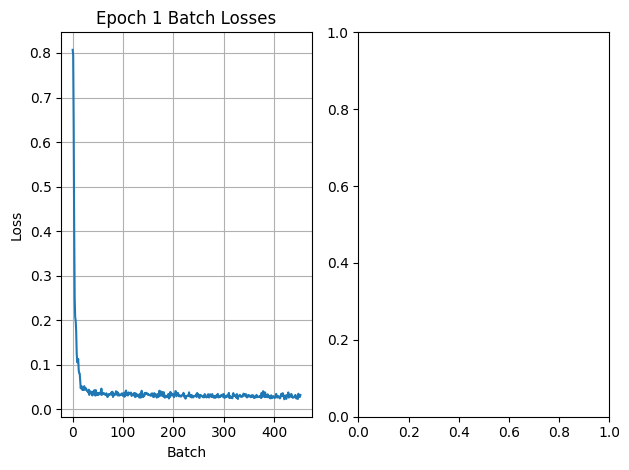

In [ ]:
import torch
import time
import math
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output


# Get caption embedding
def get_caption_embedding(caption, tokenizer, model, device=torch.device("cuda")):
    inputs = tokenizer(caption, return_tensors='pt', truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        cls_embedding = last_hidden_state[:, 0, :]  # CLS token embedding

    return cls_embedding.squeeze().to(device)

# Combined loss - Cosine + MSE
def hybrid_loss(output, target):
    mse = nn.MSELoss()(output, target)
    cosine = 1 - nn.CosineSimilarity()(output, target).mean()
    return 0.7*cosine + 0.3*mse  # Weighted combination

def train_model(num_epochs, loader, image_encoder, caption_lstm, optimizer, scheduler,
                tokenizer, bert_model, device, grad_clip_value=1.0):

    # Initialize tracking
    train_losses = []
    epoch_times = []
    best_loss = float('inf')

    # Create figure for live plotting
    plt.figure(figsize=(12, 5))

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        batch_losses = []

        # Initialize progress bar
        pbar = tqdm(enumerate(loader), total=len(loader),
                    desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

        for batch_idx, batch in pbar:
            # Get data
            images = batch['image'].to(device)
            captions = batch['caption']

            # Forward pass
            image_features = image_encoder(images)
            caption_embeddings = torch.stack([
                get_caption_embedding(cap, tokenizer, bert_model, device)
                for cap in captions
            ])

            # Enhanced LSTM forward
            outputs = caption_lstm(
                caption_embeddings.unsqueeze(1),  # [batch, 1, 768]
                image_features
            )

            # Loss calculation
            loss = hybrid_loss(outputs, caption_embeddings)
            running_loss += loss.item()
            batch_losses.append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(caption_lstm.parameters(), grad_clip_value)
            torch.nn.utils.clip_grad_norm_(image_encoder.parameters(), grad_clip_value)

            optimizer.step()
            scheduler.step()

            # Update progress bar
            avg_loss = running_loss / (batch_idx + 1)
            pbar.set_postfix({
                'batch_loss': f'{loss.item():.4f}',
                'epoch_avg': f'{avg_loss:.4f}',
                'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })

            # Live plot every 20% of epoch
            if (batch_idx + 1) % max(1, len(loader)//5) == 0:
                update_live_plot(epoch+1, batch_losses, epoch_times, len(loader))

        # Epoch complete
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        epoch_loss = running_loss / len(loader)
        train_losses.append(epoch_loss)

        # Update best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': caption_lstm.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, 'best_model.pth')

        # Print epoch summary
        print(f'\nEpoch {epoch+1} completed:')
        print(f'Avg Loss: {epoch_loss:.4f} | Time: {epoch_time:.1f}s')
        print(f'Estimated remaining: {estimate_remaining_time(epoch, num_epochs, epoch_times)}')

        # Final plot update
        update_live_plot(epoch+1, batch_losses, epoch_times, len(loader), final_update=True)

    return train_losses

def update_live_plot(current_epoch, batch_losses, epoch_times, batches_per_epoch, final_update=False):
    clear_output(wait=True)
    plt.clf()

    # Create subplots
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    # Plot batch losses
    ax1.plot(batch_losses, label='Batch Loss')
    ax1.set_title(f'Epoch {current_epoch} Batch Losses')
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Plot epoch trends if available
    if len(epoch_times) > 1:
        ax2.plot(range(1, current_epoch+1), epoch_times, 'bo-')
        ax2.set_title('Training Progress')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Time (s)')
        ax2.grid(True)

    plt.tight_layout()
    if final_update:
        plt.show()
    else:
        plt.pause(0.1)

def estimate_remaining_time(current_epoch, total_epochs, epoch_times):
    if len(epoch_times) < 2:
        return "Calculating..."

    avg_time = sum(epoch_times) / len(epoch_times)
    remaining = avg_time * (total_epochs - current_epoch - 1)

    if remaining > 3600:
        return f'{remaining/3600:.1f} hours'
    elif remaining > 60:
        return f'{remaining/60:.1f} minutes'
    else:
        return f'{remaining:.0f} seconds'

# Initialize everything
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models - Replace ImageEncoder with DeiTMedicalEncoder
image_encoder = DeiTMedicalEncoder(embed_size=768).to(device)  # Changed to DeiT
caption_lstm = CaptionLSTM(hidden_size=1024, num_layers=2).to(device)  # Updated for 768-dim inputs

# Partial unfreeze for DeiT
image_encoder._freeze_layers(unfreeze_last_n=2)  # Unfreeze last 2 transformer blocks

# Optimizer with differential learning rates
optimizer = optim.Adam([
    {'params': caption_lstm.parameters(), 'lr': 3e-4},
    {'params': image_encoder.projection.parameters(), 'lr': 1e-4},
    {'params': [p for p in image_encoder.parameters() if p.requires_grad and not any(p is x for x in image_encoder.projection.parameters())], 'lr': 5e-5}
])

# Scheduler
warmup_epochs = 3
num_epochs = 1  # Modified epoch count for memory constraints
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return 0.01 + 0.99*(epoch/warmup_epochs)
    return 0.5*(1 + math.cos(math.pi*(epoch - warmup_epochs)/(num_epochs - warmup_epochs)))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

caption_filters = [
        {'field': 'label', 'string_list': ['mri', 'head']},
        {'field': 'caption', 'string_list': ['showing', 'demonstrates', 'reveals'], 'operator': 'any'}
    ]

# Load data
loader = get_multicare_dataloader(
    dataset_name='med_test',
    batch_size=6,  # Reduced batch size for transformer model
    create_new=True,
    filters=caption_filters
)

# Start training
tokenizer = BertTokenizer.from_pretrained("MediCareBertTokenizer")
bert_model = BertModel.from_pretrained("MediCareBertModel")

train_losses = train_model(
    num_epochs=num_epochs,
    loader=loader,
    image_encoder=image_encoder,
    caption_lstm=caption_lstm,
    optimizer=optimizer,
    scheduler=scheduler,
    tokenizer=tokenizer,
    bert_model=bert_model,
    device=device
)

Using device: cuda


Some weights of BertModel were not initialized from the model checkpoint at MediCareBertModel and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading saved model checkpoint...
Loaded model from epoch 0 with loss 0.0403
Creating test dataloader...
Loading metadata from: medical_datasets/med_test/image_metadata.json
Loaded 2718 total entries from metadata file
Filtered to 2718 samples with captions
Loaded 2718 samples with valid images and captions from med_test dataset
Getting a batch from the dataloader...
Loaded batch with 4 images
Encoding images...
Creating caption embeddings...
Predicting caption embeddings...


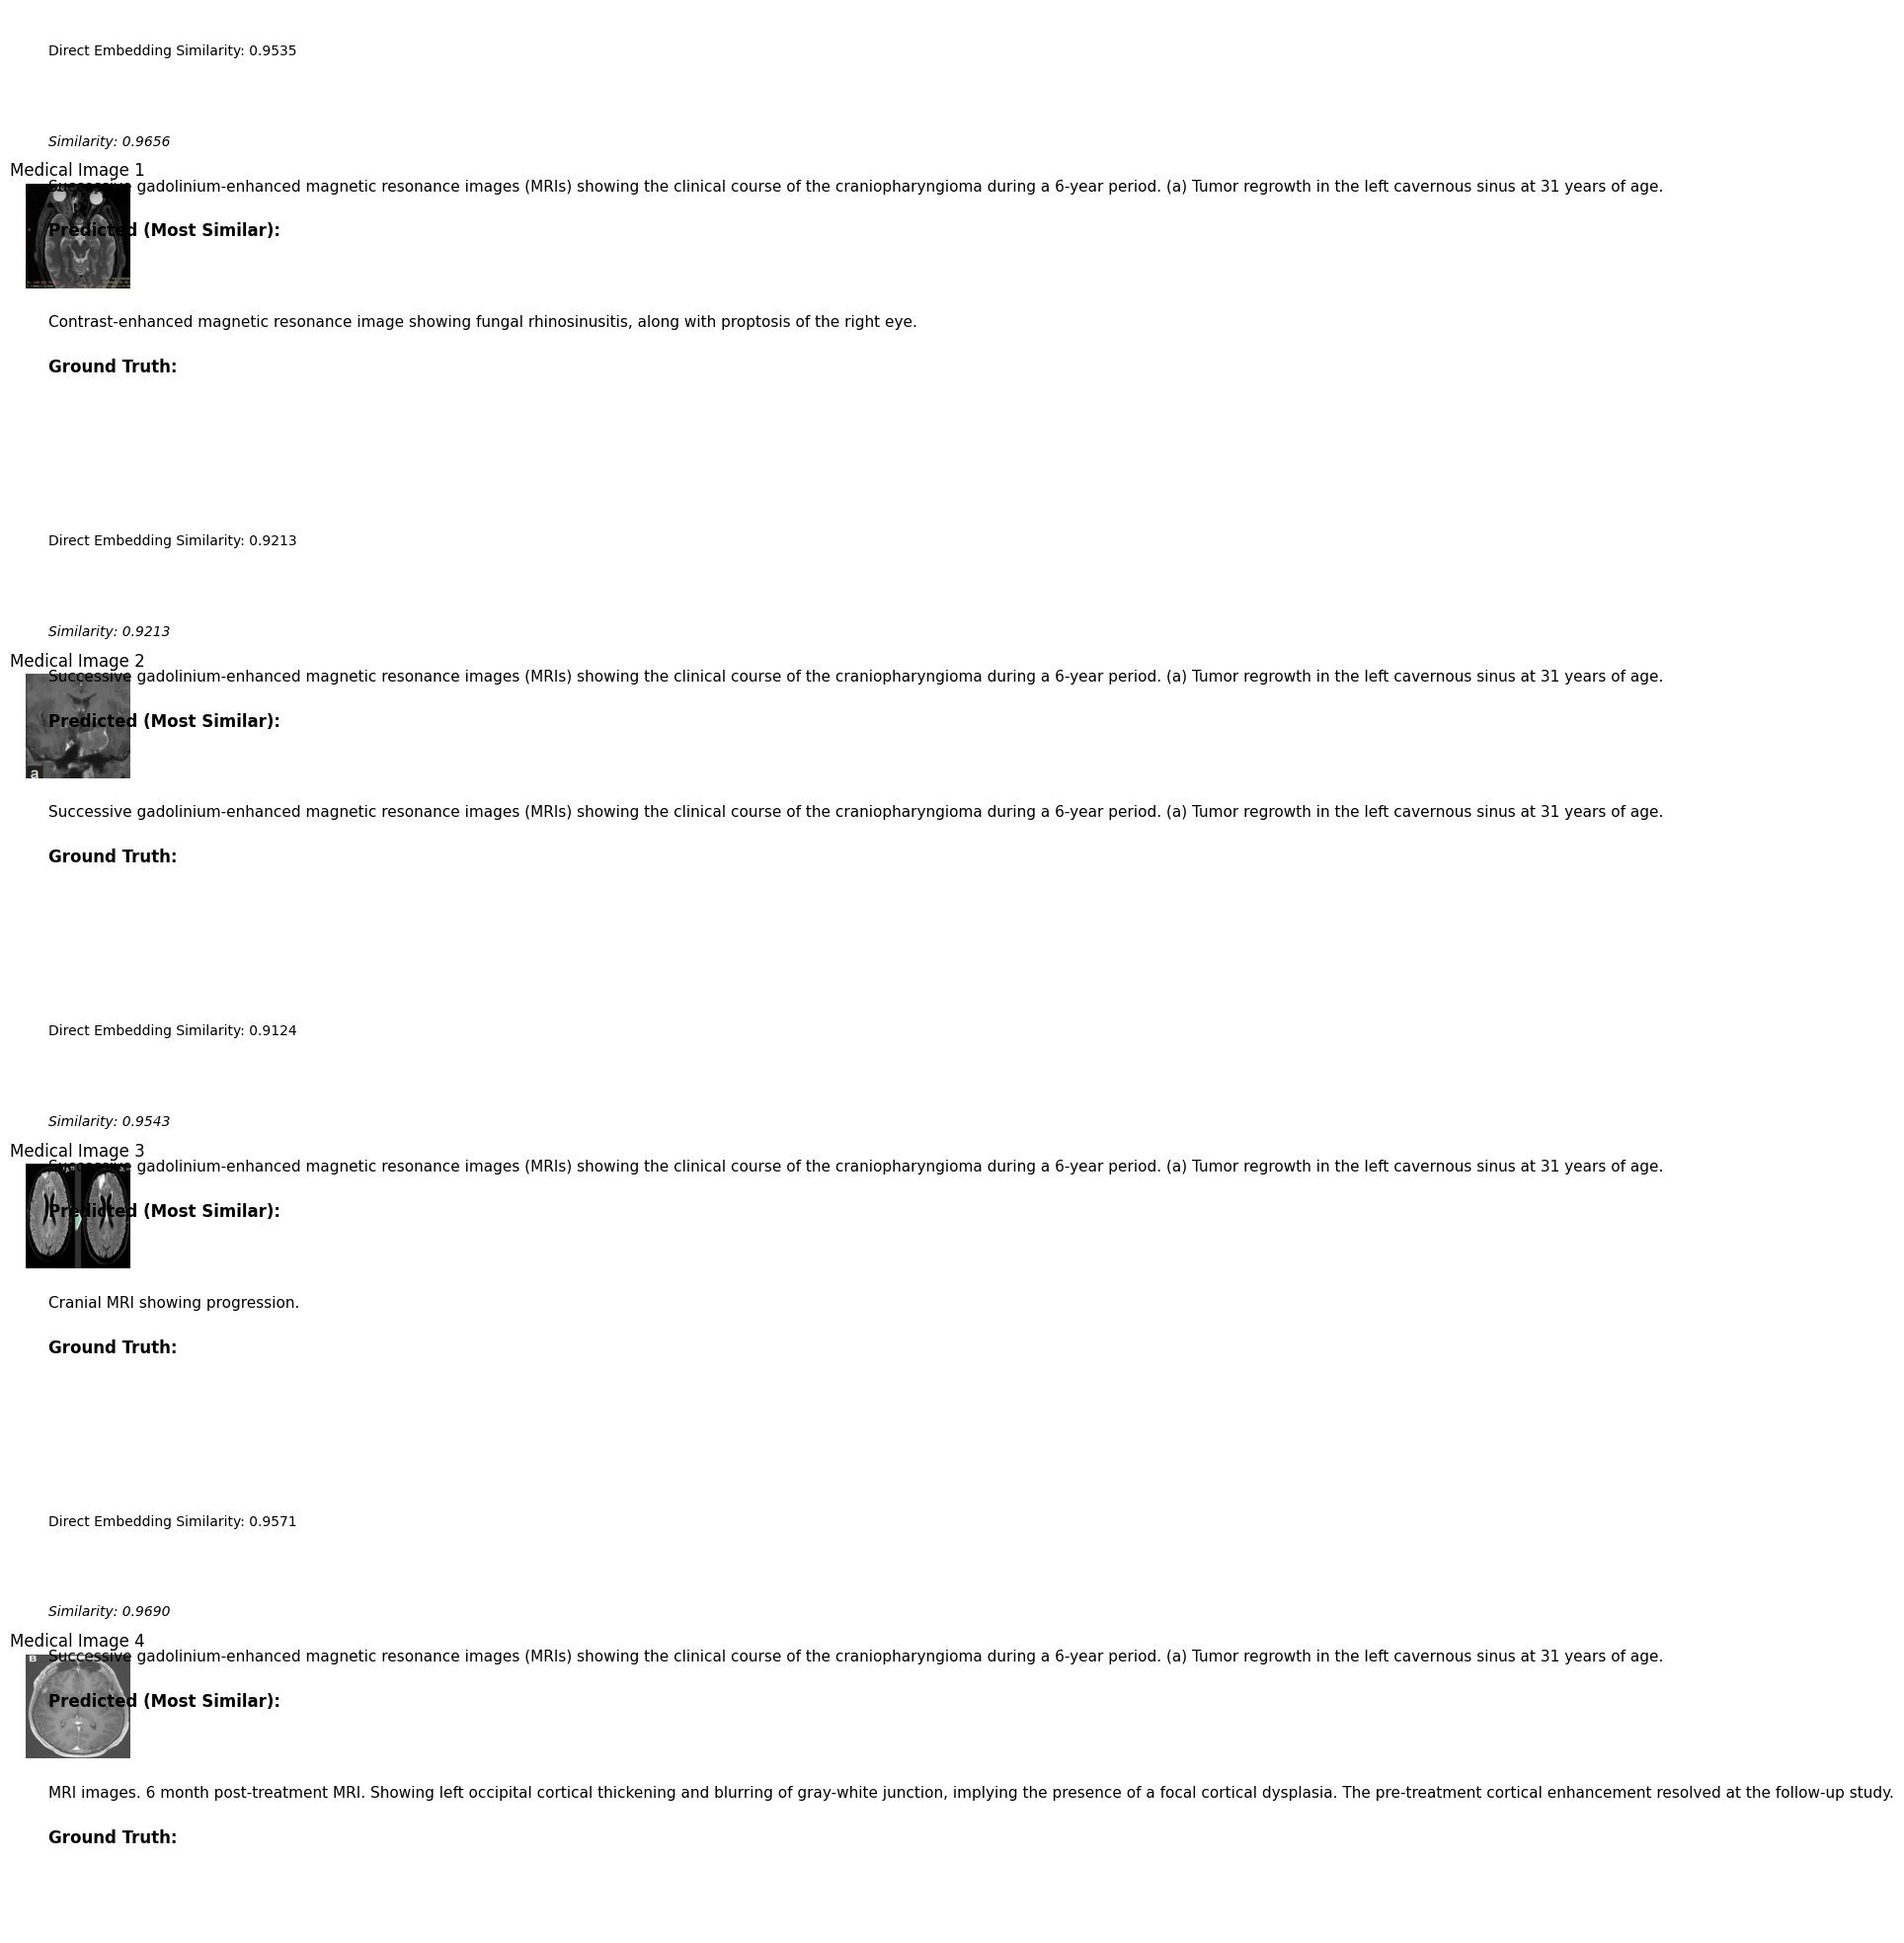

Prediction complete! Results displayed and saved to caption_predictions.png


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertModel
import torchvision.transforms as transforms


def get_caption_embedding(caption, tokenizer, model, device=torch.device("cuda")):
    """Get BERT embedding for a caption"""
    inputs = tokenizer(caption, return_tensors='pt', truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        cls_embedding = last_hidden_state[:, 0, :]  # CLS token embedding

    return cls_embedding.squeeze().to(device)


def find_most_similar_caption(pred_embedding, reference_captions, tokenizer, bert_model, device):
    """Find the most similar caption from a reference list using cosine similarity"""
    best_sim = -1
    best_caption = ""

    # Convert predicted embedding to numpy for comparison
    pred_embedding_np = pred_embedding.cpu().numpy()

    for caption in reference_captions:
        # Get embedding for reference caption
        ref_embedding = get_caption_embedding(caption, tokenizer, bert_model, device)
        ref_embedding_np = ref_embedding.cpu().numpy()

        # Calculate cosine similarity
        similarity = np.dot(pred_embedding_np, ref_embedding_np) / (
            np.linalg.norm(pred_embedding_np) * np.linalg.norm(ref_embedding_np)
        )

        if similarity > best_sim:
            best_sim = similarity
            best_caption = caption

    return best_caption, best_sim


def test_single_batch(image_encoder, caption_lstm, dataloader, tokenizer, bert_model, device):
    """
    Simple test function to predict captions for a single batch of images

    Args:
        image_encoder: DeiTMedicalEncoder model
        caption_lstm: CaptionLSTM model
        dataloader: DataLoader with test samples
        tokenizer: BERT tokenizer
        bert_model: BERT model
        device: Computation device
    """
    # Set models to evaluation mode
    image_encoder.eval()
    caption_lstm.eval()
    bert_model.eval()

    # Get a single batch from the dataloader
    print("Getting a batch from the dataloader...")
    batch = next(iter(dataloader))
    images = batch['image'].to(device)
    true_captions = batch['caption']

    print(f"Loaded batch with {len(true_captions)} images")

    # For visualization: denormalize images
    inv_normalize = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    ])

    # Forward pass through the model
    with torch.no_grad():
        # Get image features from DeiT encoder
        print("Encoding images...")
        image_features = image_encoder(images)

        # Create embeddings for all true captions to use as a reference bank
        print("Creating caption embeddings...")
        all_captions = []
        for batch_captions in true_captions:
            all_captions.append(batch_captions)

        # For each image, predict the caption embedding
        print("Predicting caption embeddings...")
        predictions = []
        for i in range(images.size(0)):
            # Create dummy caption input (zeros)
            dummy_input = torch.zeros(1, 1, 768).to(device)

            # Predict caption embedding
            pred_embedding = caption_lstm(dummy_input, image_features[i].unsqueeze(0))
            predictions.append(pred_embedding.squeeze())

    # Create a figure to display results
    num_images = min(4, images.size(0))  # Show up to 4 images
    plt.figure(figsize=(15, 5 * num_images))

    for i in range(num_images):
        # Display image
        plt.subplot(num_images, 2, i*2+1)
        img = inv_normalize(images[i].cpu()).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Medical Image {i+1}")
        plt.axis('off')

        # Display captions
        plt.subplot(num_images, 2, i*2+2)
        plt.axis('off')

        # Get true caption
        true_caption = true_captions[i]

        # Find most similar caption
        similar_caption, similarity = find_most_similar_caption(
            predictions[i],
            all_captions,
            tokenizer,
            bert_model,
            device
        )

        # Display true and predicted captions
        plt.text(0, 0.2, "Ground Truth:", fontweight='bold', fontsize=12)
        plt.text(0, 0.3, true_caption, fontsize=11)

        plt.text(0, 0.5, "Predicted (Most Similar):", fontweight='bold', fontsize=12)
        plt.text(0, 0.6, similar_caption, fontsize=11)
        plt.text(0, 0.7, f"Similarity: {similarity:.4f}", fontsize=10, style='italic')

        # Calculate BERT embedding similarity between true and predicted
        true_emb = get_caption_embedding(true_caption, tokenizer, bert_model, device)
        pred_emb = predictions[i]

        # Calculate cosine similarity
        cos_sim = torch.nn.functional.cosine_similarity(
            true_emb.unsqueeze(0),
            pred_emb.unsqueeze(0)
        ).item()

        plt.text(0, 0.9, f"Direct Embedding Similarity: {cos_sim:.4f}", fontsize=10)

    plt.tight_layout()
    plt.savefig('caption_predictions.png')
    plt.show()

    print("Prediction complete! Results displayed and saved to caption_predictions.png")
    return predictions, true_captions


# Main execution
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load models
    image_encoder = DeiTMedicalEncoder(embed_size=768).to(device)
    caption_lstm = CaptionLSTM(hidden_size=1024, num_layers=2).to(device)

    # Load BERT for text processing
    tokenizer = BertTokenizer.from_pretrained("MediCareBertTokenizer")
    bert_model = BertModel.from_pretrained("MediCareBertModel")

    # Load best checkpoint
    print("Loading saved model checkpoint...")
    checkpoint = torch.load('best_model.pth', map_location=device)
    caption_lstm.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")

    # Create test dataloader
    print("Creating test dataloader...")
    test_loader = get_multicare_dataloader(
        dataset_name='med_test',
        batch_size=4,
        create_new=False,  # Use existing dataset
    )

    # Run the test
    predictions, true_captions = test_single_batch(
        image_encoder,
        caption_lstm,
        test_loader,
        tokenizer,
        bert_model,
        device
    )

Using device: cuda


Some weights of BertModel were not initialized from the model checkpoint at MediCareBertModel and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading metadata from: medical_datasets/med_test/image_metadata.json
Loaded 2718 total entries from metadata file
Filtered to 2718 samples with captions
Loaded 2718 samples with valid images and captions from med_test dataset
Creating caption embedding lookup table...
Created lookup table with 40 captions


<ipython-input-13-d6a68c7eea49>:186: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


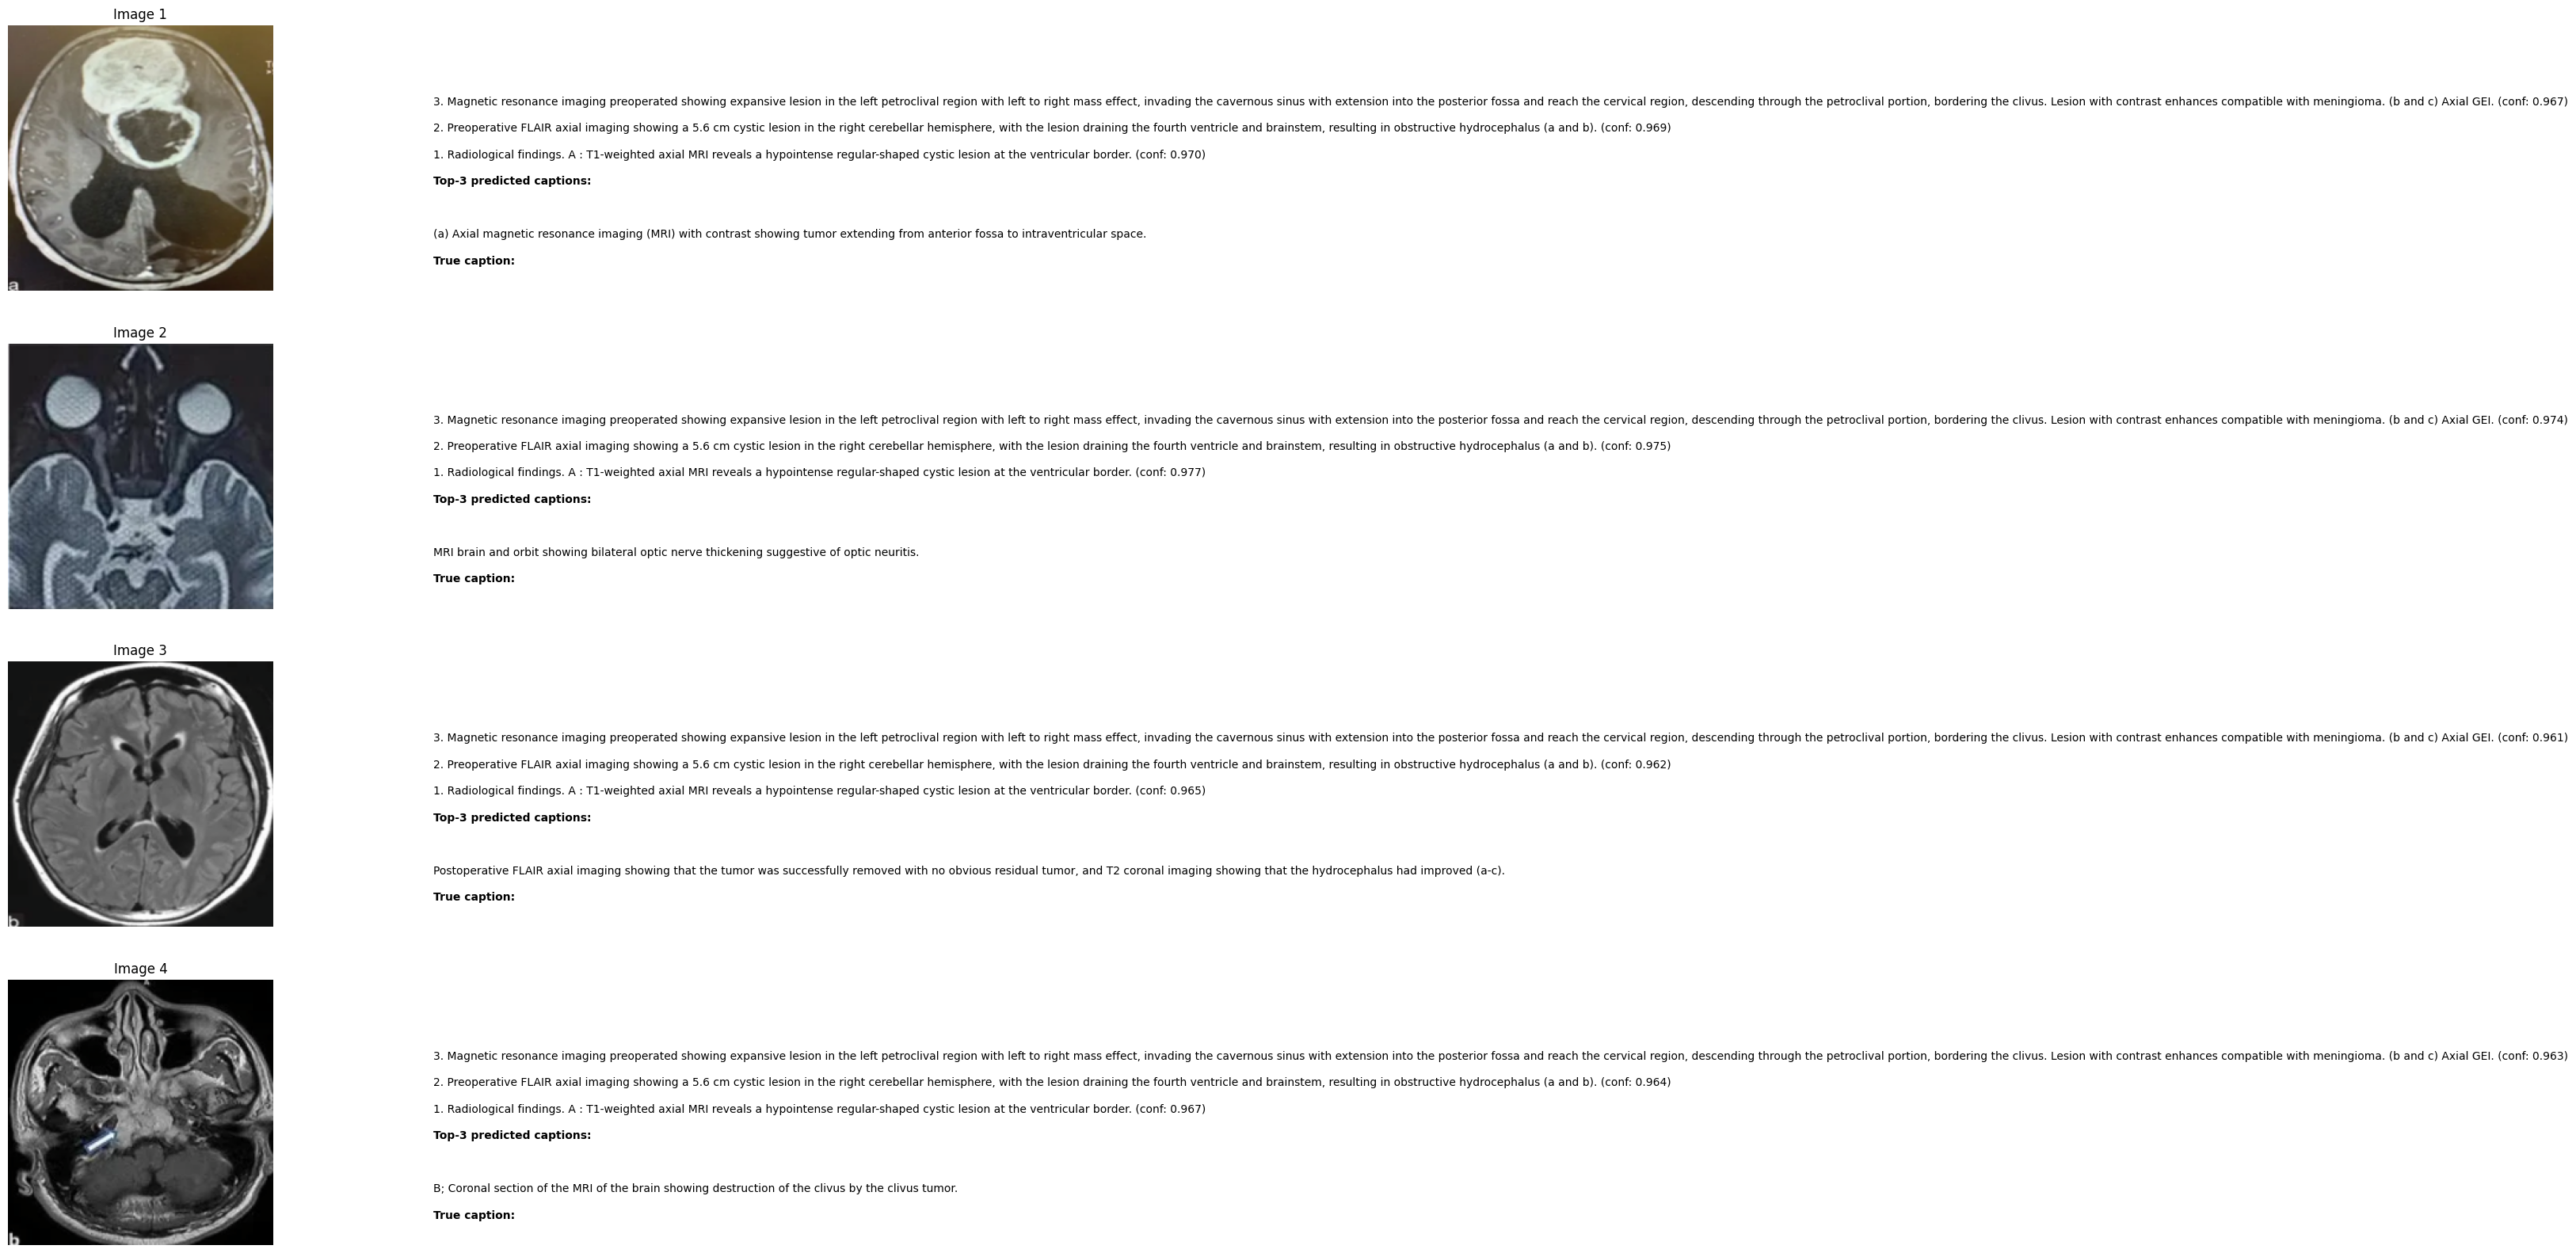

In [ ]:
import torch
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F

def test_model(model_path, deit_encoder, caption_lstm, dataloader, tokenizer, bert_model, device, top_k=5):
    """
    Test the image captioning model on a sample batch

    Args:
        model_path: Path to saved model checkpoint
        deit_encoder: Vision transformer encoder
        caption_lstm: Caption decoder LSTM
        dataloader: DataLoader containing test samples
        tokenizer: BERT tokenizer
        bert_model: BERT model for embedding comparison
        device: Computation device (cuda/cpu)
        top_k: Number of closest captions to retrieve
    """
    # Load model checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    caption_lstm.load_state_dict(checkpoint['model_state_dict'])

    # Set models to evaluation mode
    deit_encoder.eval()
    caption_lstm.eval()
    bert_model.eval()

    # Get a batch from the dataloader
    batch = next(iter(dataloader))
    images = batch['image'].to(device)
    true_captions = batch['caption']

    # Create a caption embedding lookup table from the dataset
    print("Creating caption embedding lookup table...")
    caption_bank = []
    embedding_bank = []

    # Process a subset of the dataloader to create reference embeddings
    # In production, you'd save this to disk for faster retrieval
    for i, sample_batch in enumerate(dataloader):
        if i >= 10:  # Limit to 10 batches for speed
            break
        for caption in sample_batch['caption']:
            caption_bank.append(caption)
            with torch.no_grad():
                embedding = get_caption_embedding(caption, tokenizer, bert_model, device)
                embedding_bank.append(embedding.cpu().numpy())

    embedding_bank = np.vstack(embedding_bank)
    print(f"Created lookup table with {len(caption_bank)} captions")

    # Forward pass for prediction
    with torch.no_grad():
        # Get image features
        image_features = deit_encoder(images)

        # For each image, predict caption embedding
        predicted_embeddings = []
        for i in range(images.size(0)):
            # Use a dummy caption embedding input (zero tensor)
            dummy_input = torch.zeros(1, 1, 768).to(device)

            # Get the predicted embedding
            pred_embedding = caption_lstm(dummy_input, image_features[i].unsqueeze(0))
            predicted_embeddings.append(pred_embedding.cpu().numpy())

    # Show results
    display_results(images, true_captions, predicted_embeddings,
                   caption_bank, embedding_bank, top_k)

    return predicted_embeddings


def get_caption_embedding(caption, tokenizer, model, device=torch.device("cuda")):
    """
    Get BERT embedding for a caption

    Args:
        caption: Text caption
        tokenizer: BERT tokenizer
        model: BERT model
        device: Computation device

    Returns:
        Caption embedding tensor
    """
    inputs = tokenizer(caption, return_tensors='pt', truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        cls_embedding = last_hidden_state[:, 0, :]  # CLS token embedding

    return cls_embedding.squeeze().to(device)


def find_closest_captions(pred_embedding, embedding_bank, caption_bank, top_k=5):
    """
    Find the closest captions to a predicted embedding

    Args:
        pred_embedding: Predicted embedding
        embedding_bank: Bank of reference embeddings
        caption_bank: Corresponding captions
        top_k: Number of top matches to return

    Returns:
        List of top-k closest captions
    """
    # Calculate cosine similarities
    similarities = cosine_similarity(pred_embedding, embedding_bank).flatten()

    # Get indices of top-k matches
    top_indices = np.argsort(similarities)[-top_k:][::-1]

    # Get corresponding captions and similarities
    top_captions = [caption_bank[i] for i in top_indices]
    top_similarities = [similarities[i] for i in top_indices]

    return list(zip(top_captions, top_similarities))


def display_results(images, true_captions, predicted_embeddings,
                   caption_bank, embedding_bank, top_k=5):
    """
    Display images along with true and predicted captions

    Args:
        images: Batch of images
        true_captions: Ground truth captions
        predicted_embeddings: Model predicted embeddings
        caption_bank: Bank of reference captions
        embedding_bank: Bank of reference embeddings
        top_k: Number of top matches to display
    """
    batch_size = images.size(0)

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 5 * batch_size))

    # Standard image transforms for display
    inv_normalize = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    ])

    for i in range(batch_size):
        # Display image
        plt.subplot(batch_size, 2, i*2+1)
        img = inv_normalize(images[i].cpu()).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')

        # Display captions
        plt.subplot(batch_size, 2, i*2+2)
        plt.axis('off')

        # True caption
        plt.text(0, 0.1, f"True caption:", fontweight='bold')
        plt.text(0, 0.2, true_captions[i])

        # Find closest captions to the predicted embedding
        closest_captions = find_closest_captions(
            predicted_embeddings[i],
            embedding_bank,
            caption_bank,
            top_k
        )

        # Display predicted captions
        plt.text(0, 0.4, f"Top-{top_k} predicted captions:", fontweight='bold')
        for j, (caption, similarity) in enumerate(closest_captions):
            plt.text(0, 0.5 + j*0.1, f"{j+1}. {caption} (conf: {similarity:.3f})")

    plt.tight_layout()
    plt.show()


# Main testing function
def main():
    # Load models and data
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize models
    deit_encoder = DeiTMedicalEncoder(embed_size=768).to(device)
    caption_lstm = CaptionLSTM(hidden_size=1024, num_layers=2).to(device)

    # Load tokenizer and BERT model
    tokenizer = BertTokenizer.from_pretrained("MediCareBertTokenizer")
    bert_model = BertModel.from_pretrained("MediCareBertModel")

    # Load dataloader with a smaller batch size for testing
    """
    test_loader = get_multicare_dataloader(
        dataset_name='med_test',
        batch_size=4,
        split='test',  # Use test split
        shuffle=True
    )
    """
    test_loader = get_multicare_dataloader(
        dataset_name='med_test',
        batch_size=4,  # Reduced batch size for transformer model
        create_new=True,
        filters=caption_filters
    )

    # Run test
    test_model(
        model_path='/content/best_model.pth',
        deit_encoder=deit_encoder,
        caption_lstm=caption_lstm,
        dataloader=test_loader,
        tokenizer=tokenizer,
        bert_model=bert_model,
        device=device,
        top_k=3
    )


if __name__ == "__main__":
    main()

#### Original Training Code

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from transformers import BertTokenizer, BertModel

# Load embedding model
def load_embedding_model(model_path="MediCareBert"):
    #tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    #model = BertModel.from_pretrained("bert-base-uncased")
    tokenizer = BertTokenizer.from_pretrained("/content/MediCareBertTokenizer")
    model = BertModel.from_pretrained("/content/MediCareBertModel")
    model.eval()
    return tokenizer, model

# Get caption embedding
def get_caption_embedding(caption, tokenizer, model, device=torch.device("cpu")):
    inputs = tokenizer(caption, return_tensors='pt', truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        cls_embedding = last_hidden_state[:, 0, :]  # CLS token embedding

    return cls_embedding.squeeze().to(device)

# Define CNN for image feature extraction
class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super(ImageEncoder, self).__init__()
        resnet = models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return features

# Define LSTM for caption generation
class CaptionLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers):
        super(CaptionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Projection layers
        self.bert_projection = nn.Linear(768, embed_size)
        self.image_projection = nn.Linear(embed_size, hidden_size)

        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 768)

    def forward(self, captions, image_features):
        captions = self.bert_projection(captions)  # Project BERT embeddings to LSTM input size

        if captions.dim() == 2:
            captions = captions.unsqueeze(0)  # (seq_length, embed_size) -> (1, seq_length, embed_size)

        batch_size = captions.size(0)  # Get batch size from captions

        # Ensure h0 and c0 match batch size of captions
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(image_features.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(image_features.device)

        out, _ = self.lstm(captions, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_encoder = ImageEncoder(embed_size=256).to(device)
caption_lstm = CaptionLSTM(embed_size=256, hidden_size=512, num_layers=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(caption_lstm.parameters(), lr=1e-4)

# Load tokenizer and embedding model
tokenizer, bert_model = load_embedding_model("MediCareBert")

# Load dataset using helper function
try:
    loader = get_multicare_dataloader(
        dataset_name='med_test',
        batch_size=8,
        create_new=True,
        filters=caption_filters
    )
except Exception as e:
    print(f"Error creating dataloader: {e}")
    exit()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in loader:
        images = batch['image'].to(device)
        captions = batch['caption']

        # Extract image features
        image_features = image_encoder(images)

        # Get caption embeddings
        caption_embeddings = torch.stack([
            get_caption_embedding(cap, tokenizer, bert_model, device) for cap in captions
        ])

        # Forward pass
        outputs = caption_lstm(caption_embeddings, image_features)
        loss = criterion(outputs, caption_embeddings)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

for batch in loader:
    images = batch['image'].to(device)
    captions = batch['caption']
    print(images[1].shape)
    print(captions[1])

    # Extract image features
    image_features = image_encoder(images)
    print(image_features[0])
    break

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([3, 224, 224])
(a-b). Five-week postoperative magnetic resonance imaging showing a pseudomeningocele due to recurrent hydrocephalus.
tensor([-6.1756e-01, -5.9283e-01,  1.5574e-01, -7.3464e-02, -2.1710e-01,
         1.9599e-01,  5.4039e-01, -8.3812e-01, -1.8299e-01, -8.5704e-02,
         7.2442e-01, -5.7831e-01,  4.8748e-01,  8.4660e-01,  2.5843e-01,
         5.8063e-01, -1.9695e-01, -5.3271e-01,  5.3265e-01, -2.0443e-01,
         1.1469e+00, -4.2972e-01,  1.0591e-01,  1.3484e-01,  3.8948e-01,
        -7.8099e-01, -3.0843e-01, -9.0442e-01,  3.6514e-01,  5.8464e-01,
        -3.5460e-02, -5.4091e-03, -1.9856e-01,  3.1792e-01, -1.1980e+00,
         6.5751e-01,  1.4213e-01,  2.7330e-02,  3.5573e-01, -6.2928e-01,
        -7.2061e-01, -5.1864e-01,  2.9869e-01, -1.1107e-01,  8.7245e-01,
        -1.6352e-01, -1.0686e-01,  4.1064e-01, -8.7461e-01, -8.7209e-01,
        -7.6311e-01, -3.4952e-01, -6.9456e-01,  1.5254e-01, -1.4532e-01,
         3.3929e-01, -3.3696e-01,  1.0654e+00,  4.245

#### Test 2

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import math
from collections import Counter
import random

# Vision Transformer Encoder (same as your current one)
class DeiTMedicalEncoder(nn.Module):
    def __init__(self, embed_size=768, model_name='deit_small_patch16_224', pretrained=True, spatial_output=True):
        """
        Medical image encoder based on DeiT (Data-efficient image Transformer)

        Args:
            embed_size: Output embedding size
            model_name: DeiT model variant
            pretrained: Whether to use pretrained weights
            spatial_output: Whether to return spatial features
        """
        super(DeiTMedicalEncoder, self).__init__()

        self.spatial_output = spatial_output

        # Load pretrained DeiT model
        self.deit = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,  # Remove classification head
        )

        # Get feature dimension from DeiT
        if 'small' in model_name:
            self.feature_dim = 384  # DeiT-small hidden dimension
        elif 'tiny' in model_name:
            self.feature_dim = 192  # DeiT-tiny hidden dimension
        elif 'base' in model_name:
            self.feature_dim = 768  # DeiT-base hidden dimension

        # Projection to desired embedding size
        self.projection = nn.Sequential(
            nn.Linear(self.feature_dim, embed_size),
            nn.LayerNorm(embed_size)
        )

        # Unfreeze only the last transformer blocks for efficiency
        self._freeze_layers(unfreeze_last_n=4)

    def _freeze_layers(self, unfreeze_last_n=4):
        """Freeze all layers except the last n transformer blocks"""
        # Freeze patch embedding
        for param in self.deit.patch_embed.parameters():
            param.requires_grad = False

        # Freeze position embedding
        if hasattr(self.deit, 'pos_embed'):
            self.deit.pos_embed.requires_grad = False

        # Freeze class token
        if hasattr(self.deit, 'cls_token'):
            self.deit.cls_token.requires_grad = False

        # Freeze most transformer blocks, unfreeze only the last few
        total_blocks = len(self.deit.blocks)
        for i, block in enumerate(self.deit.blocks):
            # Only unfreeze the last n blocks
            if i >= total_blocks - unfreeze_last_n:
                for param in block.parameters():
                    param.requires_grad = True
            else:
                for param in block.parameters():
                    param.requires_grad = False

    def forward(self, x):
        """
        Forward pass through DeiT encoder

        Args:
            x: Input images [batch_size, 3, 224, 224]

        Returns:
            Image features - either pooled or spatial depending on configuration
        """
        # Get features from DeiT
        if self.spatial_output:
            # Access intermediate representation with spatial information
            x = self.deit.patch_embed(x)
            if hasattr(self.deit, 'pos_embed'):
                x = x + self.deit.pos_embed[:, 1:, :]

            cls_token = self.deit.cls_token + self.deit.pos_embed[:, :1, :]
            cls_tokens = cls_token.expand(x.shape[0], -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)

            # Pass through DeiT blocks
            for block in self.deit.blocks:
                x = block(x)

            # Apply projection to all tokens
            features = self.projection(x)

            return features  # [batch_size, num_patches+1, embed_size]
        else:
            # Get CLS token output (pooled representation)
            features = self.deit(x)

            # Project to desired embedding dimension
            pooled_features = self.projection(features)

            return pooled_features  # [batch_size, embed_size]


# Vocabulary class for token management
class Vocabulary:
    def __init__(self, caption_list=None, min_word_freq=3):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        # Special tokens
        self.add_word('<PAD>')  # Padding token
        self.add_word('<START>')  # Start of sequence token
        self.add_word('<END>')  # End of sequence token
        self.add_word('<UNK>')  # Unknown word token

        # Create vocabulary from caption list if provided
        if caption_list:
            self.build_vocab(caption_list, min_word_freq)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocab(self, caption_list, min_word_freq):
        # Count word frequencies
        word_counts = Counter()
        for caption in caption_list:
            word_counts.update(caption.lower().split())

        # Add words that appear more than min_freq times
        for word, count in word_counts.items():
            if count >= min_word_freq:
                self.add_word(word)

    def __len__(self):
        return len(self.word2idx)

    def encode_caption(self, caption, max_length=50):
        """Convert caption to tensor of word indices with padding"""
        tokens = caption.lower().split()
        # Add start and end tokens
        tokens = ['<START>'] + tokens + ['<END>']

        # Encode and pad
        encoded = []
        for token in tokens:
            if token in self.word2idx:
                encoded.append(self.word2idx[token])
            else:
                encoded.append(self.word2idx['<UNK>'])

        # Apply length limit
        if len(encoded) > max_length:
            encoded = encoded[:max_length-1] + [self.word2idx['<END>']]

        # Get actual length (for pack_padded_sequence)
        length = len(encoded)

        # Pad to max_length
        while len(encoded) < max_length:
            encoded.append(self.word2idx['<PAD>'])

        return torch.tensor(encoded), length

    def decode_caption(self, indices):
        """Convert tensor of indices to caption"""
        words = []
        for idx in indices:
            if idx == self.word2idx['<END>']:
                break
            elif idx == self.word2idx['<START>'] or idx == self.word2idx['<PAD>']:
                continue
            else:
                words.append(self.idx2word.get(idx.item(), '<UNK>'))

        return ' '.join(words)


# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sin/cos positional encoding
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register buffer (not a parameter but part of the module)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        """
        Add positional encoding to input embeddings

        Args:
            x: Input embeddings [batch_size, seq_len, embedding_dim]

        Returns:
            Embeddings with positional encoding added
        """
        x = x + self.pe[:, :x.size(1), :]
        return x


# Attention mechanism for Transformer
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        # Output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear projections and reshape for multi-head attention
        q = self.q_proj(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to get attention weights
        attn_weights = F.softmax(scores, dim=-1)

        # Apply attention weights to values
        attn_output = torch.matmul(attn_weights, v)

        # Reshape and concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)

        # Final projection
        output = self.out_proj(attn_output)

        return output, attn_weights


# Transformer decoder for captioning
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, num_heads=8, num_layers=6,
                 dropout=0.1, max_len=100):
        super(TransformerDecoder, self).__init__()

        # Word embedding layer
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim, max_len)

        # Transformer decoder layers
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(embed_dim, num_heads, dropout)
            for _ in range(num_layers)
        ])

        # Final output projection
        self.fc_out = nn.Linear(embed_dim, vocab_size)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Initialize parameters
        self._init_parameters()

    def _init_parameters(self):
        """Initialize parameters with Xavier uniform distribution"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_square_subsequent_mask(self, sz):
        """Generate a square mask for the sequence to prevent attending to future positions"""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, captions, encoder_output, tgt_mask=None, tgt_key_padding_mask=None):
        """
        Forward pass for training

        Args:
            captions: Token IDs [batch_size, seq_len]
            encoder_output: Image features [batch_size, num_patches, embed_dim]
            tgt_mask: Target sequence mask (optional)
            tgt_key_padding_mask: Target key padding mask (optional)

        Returns:
            Output logits [batch_size, seq_len, vocab_size]
        """
        batch_size, seq_len = captions.shape

        # Embed captions
        caption_embeds = self.embed(captions)  # [batch_size, seq_len, embed_dim]

        # Add positional encoding
        caption_embeds = self.pos_encoding(caption_embeds)

        # Apply dropout
        caption_embeds = self.dropout(caption_embeds)

        # Generate causal mask if not provided
        if tgt_mask is None:
            device = captions.device
            tgt_mask = self.generate_square_subsequent_mask(seq_len).to(device)

        # Process through decoder layers
        output = caption_embeds
        for layer in self.layers:
            output = layer(output, encoder_output, tgt_mask, tgt_key_padding_mask)

        # Project to vocabulary size
        logits = self.fc_out(output)

        return logits

    def sample(self, encoder_output, vocab, max_length=50, beam_size=5, temperature=1.0):
        """
        Generate captions using beam search

        Args:
            encoder_output: Image features from encoder [batch_size, num_patches, embed_dim]
            vocab: Vocabulary object
            max_length: Maximum caption length
            beam_size: Beam width for beam search
            temperature: Softmax temperature

        Returns:
            List of generated captions
        """
        batch_size = encoder_output.size(0)
        device = encoder_output.device

        # Process one image at a time
        all_captions = []

        for i in range(batch_size):
            # Get encoder output for this image
            enc_output = encoder_output[i].unsqueeze(0)  # [1, num_patches, embed_dim]

            # Initialize with start token
            start_token = torch.tensor([[vocab.word2idx['<START>']]], device=device)

            # Initialize beams: (log_prob, caption_ids, finished_flag)
            beams = [(0.0, start_token, False)]

            # Beam search
            for step in range(max_length - 1):  # -1 because we already have <START>
                candidates = []

                # Process all beams
                for log_prob, caption_ids, finished in beams:
                    # Skip finished beams
                    if finished:
                        candidates.append((log_prob, caption_ids, finished))
                        continue

                    # Generate causal mask
                    tgt_mask = self.generate_square_subsequent_mask(caption_ids.size(1)).to(device)

                    # Forward pass through decoder
                    with torch.no_grad():
                        output = self.forward(caption_ids, enc_output, tgt_mask)

                    # Get probabilities for next word
                    logits = output[0, -1, :] / temperature
                    log_probs = F.log_softmax(logits, dim=-1)

                    # Get top-k next words
                    topk_log_probs, topk_indices = log_probs.topk(beam_size)

                    # Create new candidates
                    for j, (next_log_prob, next_idx) in enumerate(zip(topk_log_probs, topk_indices)):
                        # Create new caption by appending the new word
                        new_caption_ids = torch.cat([
                            caption_ids,
                            torch.tensor([[next_idx]], device=device)
                        ], dim=1)

                        # Calculate new log probability
                        new_log_prob = log_prob + next_log_prob.item()

                        # Check if this caption is finished
                        is_finished = (next_idx == vocab.word2idx['<END>'])

                        # Add to candidates
                        candidates.append((new_log_prob, new_caption_ids, is_finished))

                # Select top-k beams for next step
                beams = sorted(candidates, key=lambda x: x[0], reverse=True)[:beam_size]

                # Early stopping if all beams are finished
                if all(finished for _, _, finished in beams):
                    break

            # Select best beam
            best_caption = sorted(beams, key=lambda x: x[0], reverse=True)[0][1]

            # Convert to text
            caption_text = vocab.decode_caption(best_caption[0])
            all_captions.append(caption_text)

        return all_captions

    def greedy_decode(self, encoder_output, vocab, max_length=50):
        """
        Generate captions using greedy decoding

        Args:
            encoder_output: Image features from encoder [batch_size, num_patches, embed_dim]
            vocab: Vocabulary object
            max_length: Maximum caption length

        Returns:
            List of generated captions
        """
        batch_size = encoder_output.size(0)
        device = encoder_output.device

        # Initialize with start token
        tokens = torch.full((batch_size, 1), vocab.word2idx['<START>'], dtype=torch.long, device=device)

        # Generate tokens step by step
        for step in range(max_length - 1):  # -1 because we already have <START>
            # Generate mask
            tgt_mask = self.generate_square_subsequent_mask(tokens.size(1)).to(device)

            # Forward pass
            with torch.no_grad():
                output = self.forward(tokens, encoder_output, tgt_mask)

            # Get next words
            next_token_logits = output[:, -1, :]
            next_tokens = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            # Append to sequence
            tokens = torch.cat([tokens, next_tokens], dim=-1)

            # Check if all sequences have END token
            if (next_tokens == vocab.word2idx['<END>']).all():
                break

        # Convert sequences to text
        captions = []
        for seq in tokens:
            caption = vocab.decode_caption(seq)
            captions.append(caption)

        return captions


# Transformer decoder layer
class TransformerDecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()

        # Self-attention
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)

        # Cross-attention (to encoder outputs)
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim)
        )

        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, tgt_mask=None, tgt_key_padding_mask=None):
        """
        Forward pass for a single decoder layer

        Args:
            x: Target sequence [batch_size, seq_len, embed_dim]
            memory: Encoder output [batch_size, src_len, embed_dim]
            tgt_mask: Target sequence mask
            tgt_key_padding_mask: Target key padding mask

        Returns:
            Layer output
        """
        # Prepare for attention (transpose for PyTorch attention)
        q = k = v = x.transpose(0, 1)  # [seq_len, batch_size, embed_dim]
        memory = memory.transpose(0, 1)  # [src_len, batch_size, embed_dim]

        # Self-attention
        attn_output, _ = self.self_attn(
            q, k, v,
            attn_mask=tgt_mask,
            key_padding_mask=tgt_key_padding_mask
        )

        # Residual connection and layer norm
        x = x + self.dropout(attn_output.transpose(0, 1))
        x = self.norm1(x)

        # Cross-attention with encoder outputs
        q = x.transpose(0, 1)
        attn_output, _ = self.multihead_attn(
            q, memory, memory
        )

        # Residual connection and layer norm
        x = x + self.dropout(attn_output.transpose(0, 1))
        x = self.norm2(x)

        # Feed-forward network
        ffn_output = self.ffn(x)

        # Final residual connection and layer norm
        x = x + self.dropout(ffn_output)
        x = self.norm3(x)

        return x


# Complete Medical Captioning Model with Transformer
class MedicalCaptioningTransformer(nn.Module):
    def __init__(self, vocab, embed_dim=512, num_heads=8, num_layers=6, dropout=0.1):
        super(MedicalCaptioningTransformer, self).__init__()

        # Store vocabulary
        self.vocab = vocab

        # Image encoder with spatial features
        self.image_encoder = DeiTMedicalEncoder(
            embed_size=embed_dim,
            spatial_output=True  # Get spatial features for transformer
        )

        # Caption decoder (transformer)
        self.caption_decoder = TransformerDecoder(
            vocab_size=len(vocab),
            embed_dim=embed_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            dropout=dropout
        )

    def forward(self, images, captions, tgt_mask=None, tgt_key_padding_mask=None):
        """
        Forward pass for training

        Args:
            images: Input images [batch_size, 3, 224, 224]
            captions: Ground truth caption indices [batch_size, seq_len]
            tgt_mask: Target sequence mask (optional)
            tgt_key_padding_mask: Target key padding mask (optional)

        Returns:
            Vocabulary distribution at each time step
        """
        # Encode images with spatial features
        image_features = self.image_encoder(images)  # [batch_size, num_patches+1, embed_dim]

        # Generate caption with transformer decoder
        outputs = self.caption_decoder(
            captions,
            image_features,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        return outputs

    def generate_padding_mask(self, captions):
        """Generate padding mask for transformer"""
        padding_mask = (captions == self.vocab.word2idx['<PAD>'])
        return padding_mask

    def generate_caption(self, images, method="beam", beam_size=5, max_length=50):
        """
        Generate captions during inference

        Args:
            images: Input images [batch_size, 3, 224, 224]
            method: "beam" or "greedy"
            beam_size: Beam search width
            max_length: Maximum caption length

        Returns:
            Generated captions
        """
        # No gradient tracking for inference
        with torch.no_grad():
            # Encode images
            image_features = self.image_encoder(images)

            # Generate captions
            if method == "beam":
                captions = self.caption_decoder.sample(
                    image_features,
                    self.vocab,
                    max_length=max_length,
                    beam_size=beam_size
                )
            else:
                captions = self.caption_decoder.greedy_decode(
                    image_features,
                    self.vocab,
                    max_length=max_length
                )

        return captions


# Dataset with caption encoding for transformer model
class MedicalCaptionDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, vocab, max_length=50):
        self.original_dataset = original_dataset
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        # Get original item
        item = self.original_dataset[idx]

        # Encode the caption
        caption = item['caption']
        caption_tensor, caption_length = self.vocab.encode_caption(caption, self.max_length)

        # Return with encoded caption
        return {
            'image': item['image'],
            'caption': caption_tensor,
            'caption_length': caption_length,
            'original_caption': caption
        }


# Function to build vocabulary from dataset
def build_vocabulary_from_dataset(dataset, min_word_freq=3):
    """
    Build vocabulary from captions in the dataset

    Args:
        dataset: Dataset with captions
        min_word_freq: Minimum word frequency to include in vocabulary

    Returns:
        Vocabulary object
    """
    all_captions = []

    for i in range(len(dataset)):
        caption = dataset[i]['caption']
        all_captions.append(caption)

    vocab = Vocabulary(all_captions, min_word_freq)
    print(f"Built vocabulary with {len(vocab)} words")

    return vocab


# Collate function for variable length sequences (for DataLoader)
def collate_fn(batch, pad_idx):
    """Custom collate function for handling variable length captions"""
    # Sort batch by caption length (descending) - not strictly needed for transformer
    batch = sorted(batch, key=lambda x: x['caption_length'], reverse=True)

    # Get individual components
    images = torch.stack([item['image'] for item in batch])
    captions = [item['caption'] for item in batch]
    caption_lengths = torch.tensor([item['caption_length'] for item in batch])
    original_captions = [item['original_caption'] for item in batch]

    # Pad captions to max length in batch
    max_len = max(caption_lengths)
    padded_captions = torch.ones(len(captions), max_len).long() * pad_idx

    for i, cap in enumerate(captions):
        length = caption_lengths[i]
        padded_captions[i, :length] = cap[:length]

    return {
        'image': images,
        'caption': padded_captions,
        'caption_length': caption_lengths,
        'original_caption': original_captions
    }


# Training function for transformer model
def train_transformer_model(model, train_loader, criterion, optimizer, scheduler,
                           device, num_epochs=10, clip_value=1.0):
    """
    Train the transformer captioning model

    Args:
        model: The captioning model
        train_loader: DataLoader with training data
        criterion: Loss function (typically CrossEntropyLoss)
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        device: Computing device
        num_epochs: Number of training epochs
        clip_value: Gradient clipping value
    """
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        # Progress tracking
        from tqdm import tqdm
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch_idx, batch in enumerate(progress_bar):
            # Get data
            images = batch['image'].to(device)
            captions = batch['caption'].to(device)

            # Create padding mask
            padding_mask = model.generate_padding_mask(captions)

            # Forward pass
            outputs = model(images, captions[:, :-1])  # Remove last token from input

            # Prepare target (shift right)
            targets = captions[:, 1:]  # Remove first token (<START>) from target

            # Reshape for loss calculation
            batch_size, seq_len, vocab_size = outputs.shape
            outputs = outputs.reshape(-1, vocab_size)
            targets = targets.reshape(-1)

            # Compute loss (ignore padding)
            loss = criterion(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            # Update weights
            optimizer.step()
            scheduler.step()

            # Track loss
            epoch_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'avg_loss': f'{epoch_loss/(batch_idx+1):.4f}',
                'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })

        # End of epoch
        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}')

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'transformer_model_epoch{epoch+1}.pth')

    return model


# Testing function for transformer model
def test_transformer_model(model, test_loader, device, num_samples=4):
    """
    Test the transformer captioning model

    Args:
        model: The captioning model
        test_loader: DataLoader with test data
        device: Computing device
        num_samples: Number of samples to display
    """
    model.eval()

    # Get a batch
    batch = next(iter(test_loader))
    images = batch['image'].to(device)
    original_captions = batch['original_caption']

    # Limit to num_samples
    images = images[:num_samples]
    original_captions = original_captions[:num_samples]

    # Generate captions
    with torch.no_grad():
        beam_captions = model.generate_caption(
            images, method="beam", beam_size=5, max_length=50
        )
        greedy_captions = model.generate_caption(
            images, method="greedy", max_length=50
        )

    # Display results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Display image
        plt.subplot(num_samples, 2, i*2+1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        # Un-normalize if needed
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Medical Image {i+1}")
        plt.axis('off')

        # Display captions
        plt.subplot(num_samples, 2, i*2+2)
        plt.axis('off')

        plt.text(0, 0.1, "Original Caption:", fontweight='bold', fontsize=12)
        plt.text(0, 0.2, original_captions[i], fontsize=11)

        plt.text(0, 0.4, "Beam Search Caption:", fontweight='bold', fontsize=12)
        plt.text(0, 0.5, beam_captions[i], fontsize=11)

        plt.text(0, 0.7, "Greedy Search Caption:", fontweight='bold', fontsize=12)
        plt.text(0, 0.8, greedy_captions[i], fontsize=11)

    plt.tight_layout()
    plt.savefig('transformer_captions.png')
    plt.show()

    # Print results
    print("Generated captions:")
    for i in range(num_samples):
        print(f"\nImage {i+1}:")
        print(f"Original: {original_captions[i]}")
        print(f"Beam:     {beam_captions[i]}")
        print(f"Greedy:   {greedy_captions[i]}")

    return beam_captions, greedy_captions

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import math
import time
from torch.utils.data import DataLoader



def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Set hyperparameters
    embed_dim = 512  # Embedding dimension
    num_heads = 8    # Number of attention heads
    num_layers = 6   # Number of transformer layers
    dropout = 0.1    # Dropout rate
    batch_size = 16  # Batch size

    # Learning parameters
    num_epochs = 15
    warmup_epochs = 2
    clip_value = 1.0

    # Load your existing dataset
    print("Loading medical image dataset...")
    dataset = get_multicare_dataloader(
        dataset_name='medCapAll',
        batch_size=1,  # Set to 1 to access individual samples
        create_new= True,
        filters = [{'field': 'label', 'string_list': []},
         {'field': 'caption', 'string_list': [], 'operator': 'any'}]  # Any image with caption]
    ).dataset  # Get the dataset from the dataloader

    # Build vocabulary from dataset
    print("Building vocabulary from dataset captions...")
    vocab = build_vocabulary_from_dataset(dataset, min_word_freq=2)
    
    print(f"Vocabulary size: {len(vocab)}")

    # Create transformer model
    print("Creating transformer captioning model...")
    model = MedicalCaptioningTransformer(
        vocab=vocab,
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    # Print model summary
    print(f"Model architecture:")
    print(f"- Embedding dimension: {embed_dim}")
    print(f"- Attention heads: {num_heads}")
    print(f"- Transformer layers: {num_layers}")
    print(f"- Vocabulary size: {len(vocab)}")

    # Create dataset with encoded captions
    print("Creating dataset with encoded captions...")
    captioning_dataset = MedicalCaptionDataset(dataset, vocab, max_length=50)

    # Split dataset into train/val/test
    total_size = len(captioning_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        captioning_dataset, [train_size, val_size, test_size]
    )

    print(f"Dataset split: {train_size} train, {val_size} validation, {test_size} test")

    # Create data loaders
    pad_idx = vocab.word2idx['<PAD>']

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        collate_fn=lambda x: collate_fn(x, pad_idx=pad_idx)
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=lambda x: collate_fn(x, pad_idx=pad_idx)
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=lambda x: collate_fn(x, pad_idx=pad_idx)
    )

    # Setup training
    print("Setting up training...")
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=0.1)

    # Initialize parameters with different learning rates
    encoder_params = list(model.image_encoder.parameters())
    decoder_params = list(model.caption_decoder.parameters())

    # Optimizer with differential learning rates
    optimizer = optim.AdamW([
        {'params': decoder_params, 'lr': 1e-4},
        {'params': model.image_encoder.projection.parameters(), 'lr': 5e-5},
        {'params': [p for p in encoder_params if p.requires_grad and
                   not any(p is x for x in model.image_encoder.projection.parameters())],
         'lr': 1e-5}
    ], weight_decay=0.01)

    # Learning rate scheduler with warmup and cosine decay
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        return 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Train the model
    print("Starting training...")
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        device, num_epochs=num_epochs, clip_value=clip_value
    )

    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'vocab': vocab,
        'embed_dim': embed_dim,
        'num_heads': num_heads,
        'num_layers': num_layers
    }, 'final_transformer_model.pth')

    print("Training complete and model saved!")

    # Test the model
    print("Testing model on test set...")
    test_model(model, test_loader, device)


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
               device, num_epochs=15, clip_value=1.0):
    """
    Train the transformer captioning model
    """
    # Training tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_start_time = time.time()
        train_loss = 0.0

        # Progress tracking
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader),
                          desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

        for batch_idx, batch in progress_bar:
            # Get data
            images = batch['image'].to(device)
            captions = batch['caption'].to(device)

            # Create padding mask
            padding_mask = (captions == model.vocab.word2idx['<PAD>'])

            # Forward pass
            outputs = model(images, captions[:, :-1])  # Remove last token from input

            # Prepare target (shift right)
            targets = captions[:, 1:]  # Remove first token (<START>) from target

            # Reshape for loss calculation
            batch_size, seq_len, vocab_size = outputs.shape
            outputs = outputs.reshape(-1, vocab_size)
            targets = targets.reshape(-1)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            # Update weights
            optimizer.step()

            # Track loss
            train_loss += loss.item()

            # Update progress bar
            avg_loss = train_loss / (batch_idx + 1)
            progress_bar.set_postfix({
                'batch_loss': f'{loss.item():.4f}',
                'avg_loss': f'{avg_loss:.4f}',
                'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })

        # Update learning rate scheduler
        scheduler.step()

        # Calculate average training loss for epoch
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                # Get data
                images = batch['image'].to(device)
                captions = batch['caption'].to(device)

                # Forward pass
                outputs = model(images, captions[:, :-1])  # Remove last token from input

                # Prepare target (shift right)
                targets = captions[:, 1:]  # Remove first token (<START>) from target

                # Reshape for loss calculation
                batch_size, seq_len, vocab_size = outputs.shape
                outputs = outputs.reshape(-1, vocab_size)
                targets = targets.reshape(-1)

                # Compute loss
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Check if this is the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }, 'best_transformer_model.pth')
            print(f"New best model saved with val loss: {best_val_loss:.4f}")

        # Epoch summary
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.1f}s")
        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Plot progress
        plot_training_progress(train_losses, val_losses)

    return train_losses, val_losses


def plot_training_progress(train_losses, val_losses):
    """Plot training and validation losses"""
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.plot(val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    plt.savefig('transformer_training_progress.png')
    plt.close()


def test_model(model, data_loader, device, num_samples=6):
    """Test the trained transformer model"""
    model.eval()

    # Get a batch from the dataloader
    batch = next(iter(data_loader))
    images = batch['image'].to(device)
    original_captions = batch['original_caption']

    # Limit to num_samples
    images = images[:num_samples]
    original_captions = original_captions[:num_samples]

    # Generate captions
    with torch.no_grad():
        # Generate with beam search
        beam_captions = model.generate_caption(
            images, method="beam", max_length=50, beam_size=5
        )

        # Generate with greedy search
        greedy_captions = model.generate_caption(
            images, method="greedy", max_length=50
        )

    # Display results
    plt.figure(figsize=(15, 6 * min(len(images), num_samples)))

    for i in range(min(len(images), num_samples)):
        # Display image
        plt.subplot(num_samples, 2, i*2+1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Medical Image {i+1}")
        plt.axis('off')

        # Display captions
        plt.subplot(num_samples, 2, i*2+2)
        plt.axis('off')

        plt.text(0, 0.1, "Original Caption:", fontweight='bold', fontsize=12)
        plt.text(0, 0.2, original_captions[i], fontsize=11)

        plt.text(0, 0.4, "Beam Search Caption:", fontweight='bold', fontsize=12)
        plt.text(0, 0.5, beam_captions[i], fontsize=11)

        plt.text(0, 0.7, "Greedy Search Caption:", fontweight='bold', fontsize=12)
        plt.text(0, 0.8, greedy_captions[i], fontsize=11)

    plt.tight_layout()
    plt.savefig('transformer_test_results.png')
    plt.show()

    print("\nTest Results:")
    for i in range(min(len(images), num_samples)):
        print(f"\nImage {i+1}:")
        print(f"Original: {original_captions[i]}")
        print(f"Beam:     {beam_captions[i]}")
        print(f"Greedy:   {greedy_captions[i]}")

    return beam_captions, greedy_captions


# Load saved model for inference
def load_model_for_inference(model_path, device):
    """Load a saved transformer model for inference"""
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Get model parameters
    vocab = checkpoint['vocab']
    embed_dim = checkpoint.get('embed_dim', 512)
    num_heads = checkpoint.get('num_heads', 8)
    num_layers = checkpoint.get('num_layers', 6)

    # Create model with same architecture
    model = MedicalCaptioningTransformer(
        vocab=vocab,
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_layers=num_layers
    ).to(device)

    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Set to evaluation mode
    model.eval()

    return model, vocab


if __name__ == "__main__":
    main()

Using device: cuda
Loading medical image dataset...
Loading metadata from: medical_datasets/medCapAll/image_metadata.json
Loaded 130791 total entries from metadata file
Filtered to 130791 samples with captions
Loaded 130791 samples with valid images and captions from medCapAll dataset
Building vocabulary from dataset captions...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Unexpected error loading image medical_datasets/medCapAll/images/PMC5/PMC57/PMC5784282_JLP-10-116-g001_undivided_1_1.webp: cannot identify image file 'medical_datasets/medCapAll/images/PMC5/PMC57/PMC5784282_JLP-10-116-g001_undivided_1_1.webp'


UnidentifiedImageError: cannot identify image file 'medical_datasets/medCapAll/images/PMC5/PMC57/PMC5784282_JLP-10-116-g001_undivided_1_1.webp'